In [1]:
# Initialize a new VAME project
import vame
import functions_bondjango as bd
import functions_vame as fv
import paths
import random
import os
import shutil
import h5py
import numpy as np
import importlib
import pandas as pd

In [2]:
# Manually define the config path if project has already been created
# config = r"D:\VAME_projects\VAME_prey_6-Apr28-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_7-Apr29-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May2-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-May14-2021\config.yaml"
config = r"D:\VAME_projects\VAME_prey_15dim-May17-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\config.yaml"

In [ ]:
# vame.motif_videos(config)
vame.motif_videos(config, videoType='.avi')

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 3/6 [00:00<00:00, 24.32it/s]

Cluster size is: 15 
Motif videos getting created for 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured ...
Cluster: 0


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                              | 4/11 [00:00<00:00, 37.95it/s]

Cluster: 1


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                         | 4/13 [00:00<00:00, 34.36it/s]

Cluster: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/9 [00:00<00:00, 39.02it/s]

Cluster: 3
Cluster: 4
Cluster: 5


 24%|██████████████████████████████████████████████▌                                                                                                                                                       | 4/17 [00:00<00:00, 38.67it/s]

Cluster: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.59it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                             | 0/144 [00:00<?, ?it/s]

Cluster: 7
Cluster: 8
Cluster: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:03<00:00, 36.67it/s]
0it [00:00, ?it/s]
 29%|██████████████████████████████████████████████████████████▏                                                                                                                                           | 5/17 [00:00<00:00, 40.38it/s]

Cluster: 10
Cluster: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 39.34it/s]
0it [00:00, ?it/s]
 29%|████████████████████████████████████████████████████████▌                                                                                                                                             | 4/14 [00:00<00:00, 37.91it/s]

Cluster: 12
Cluster: 13


 26%|████████████████████████████████████████████████████                                                                                                                                                  | 5/19 [00:00<00:00, 41.00it/s]

Cluster: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 37.08it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.18it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]

Motif videos getting created for 08_07_2020_17_03_26_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6


  1%|██▋                                                                                                                                                                                                  | 4/297 [00:00<00:08, 36.56it/s]

Cluster: 7


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 5/15 [00:00<00:00, 39.29it/s]

Cluster: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.30it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 31%|████████████████████████████████████████████████████████████▉                                                                                                                                         | 4/13 [00:00<00:00, 36.89it/s]

Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


 14%|██████████████████████████▊                                                                                                                                                                           | 5/37 [00:00<00:00, 40.00it/s]

Cluster: 14


  0%|                                                                                                                                                                                                              | 0/13 [00:00<?, ?it/s]

Motif videos getting created for 03_31_2021_09_45_11_miniscope_DG_210202_a_succ ...
Cluster: 0
Cluster: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.22it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                               | 0/7 [00:00<?, ?it/s]

Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.49it/s]
0it [00:00, ?it/s]
  1%|██▍                                                                                                                                                                                                  | 4/325 [00:00<00:08, 36.73it/s]

Cluster: 6
Cluster: 7


 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 4/9 [00:00<00:00, 38.31it/s]

Cluster: 8


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4/8 [00:00<00:00, 36.91it/s]

Cluster: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.40it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.16it/s]
0it [00:00, ?it/s]
 24%|███████████████████████████████████████████████▏                                                                                                                                                      | 5/21 [00:00<00:00, 45.49it/s]

Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


 14%|███████████████████████████▎                                                                                                                                                                          | 4/29 [00:00<00:00, 39.26it/s]

Cluster: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 40.54it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  1%|██▎                                                                                                                                                                                                  | 3/252 [00:00<00:09, 26.60it/s]

Motif videos getting created for 08_16_2020_16_27_15_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:06<00:00, 37.14it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.33it/s]

Cluster: 8
Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13
Cluster: 14



  2%|███                                                                                                                                                                                                  | 2/128 [00:00<00:06, 19.71it/s]

Motif videos getting created for 12_11_2019_17_14_34_miniscope_MM_191108_a_fail_miniscopeafterbonsai ...
Cluster: 0


 18%|██████████████████████████████████▉                                                                                                                                                                   | 3/17 [00:00<00:00, 27.43it/s]

Cluster: 1


 13%|██████████████████████████▍                                                                                                                                                                           | 4/30 [00:00<00:00, 36.90it/s]

Cluster: 2


  4%|████████▊                                                                                                                                                                                             | 3/67 [00:00<00:02, 28.20it/s]

Cluster: 3


 12%|███████████████████████▎                                                                                                                                                                              | 4/34 [00:00<00:00, 34.02it/s]

Cluster: 4


  3%|██████▎                                                                                                                                                                                              | 4/125 [00:00<00:03, 34.86it/s]

Cluster: 5


  8%|███████████████▌                                                                                                                                                                                      | 4/51 [00:00<00:01, 34.01it/s]

Cluster: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 34.94it/s]
0it [00:00, ?it/s]
  4%|████████▋                                                                                                                                                                                             | 4/91 [00:00<00:02, 36.32it/s]

Cluster: 7
Cluster: 8


  1%|██▌                                                                                                                                                                                                  | 4/307 [00:00<00:08, 36.85it/s]

Cluster: 9


  1%|██▊                                                                                                                                                                                                  | 4/280 [00:00<00:07, 36.66it/s]

Cluster: 10


  3%|█████▍                                                                                                                                                                                               | 5/181 [00:00<00:04, 38.89it/s]

Cluster: 11


  4%|████████▎                                                                                                                                                                                             | 4/95 [00:00<00:02, 34.30it/s]

Cluster: 12


 10%|██████████████████▊                                                                                                                                                                                   | 8/84 [00:00<00:01, 39.49it/s]

Cluster: 13


 17%|█████████████████████████████████                                                                                                                                                                     | 4/24 [00:00<00:00, 30.18it/s]

Cluster: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.63it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/23 [00:00<?, ?it/s]

Motif videos getting created for 09_06_2020_15_25_10_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.76it/s]
0it [00:00, ?it/s]
 24%|██████████████████████████████████████████████▌                                                                                                                                                       | 4/17 [00:00<00:00, 37.02it/s]

Cluster: 8
Cluster: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 39.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4/8 [00:00<00:00, 34.65it/s]

Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


 23%|█████████████████████████████████████████████                                                                                                                                                         | 5/22 [00:00<00:00, 45.73it/s]

Cluster: 14


 12%|███████████████████████▊                                                                                                                                                                              | 3/25 [00:00<00:00, 27.41it/s]

Motif videos getting created for 12_09_2019_15_08_33_miniscope_MM_191108_a_succ ...
Cluster: 0


  8%|███████████████▌                                                                                                                                                                                      | 4/51 [00:00<00:01, 37.23it/s]

Cluster: 1


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4/10 [00:00<00:00, 31.46it/s]

Cluster: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.54it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/18 [00:00<?, ?it/s]

Cluster: 3
Cluster: 4
Cluster: 5


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4/10 [00:00<00:00, 37.79it/s]

Cluster: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.89it/s]
0it [00:00, ?it/s]
 27%|████████████████████████████████████████████████████▊                                                                                                                                                 | 4/15 [00:00<00:00, 36.01it/s]

Cluster: 7
Cluster: 8


  8%|███████████████                                                                                                                                                                                       | 5/66 [00:00<00:01, 37.85it/s]

Cluster: 9


 13%|██████████████████████████▍                                                                                                                                                                           | 4/30 [00:00<00:00, 33.19it/s]

Cluster: 10


 17%|█████████████████████████████████                                                                                                                                                                     | 4/24 [00:00<00:00, 32.54it/s]

Cluster: 11


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4/8 [00:00<00:00, 33.61it/s]

Cluster: 12


 12%|████████████████████████▊                                                                                                                                                                             | 4/32 [00:00<00:00, 36.28it/s]

Cluster: 13


 28%|███████████████████████████████████████████████████████                                                                                                                                               | 5/18 [00:00<00:00, 43.21it/s]

Cluster: 14


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                | 3/11 [00:00<00:00, 26.53it/s]

Motif videos getting created for 12_07_2019_15_52_11_miniscope_MM_191108_a_succ ...
Cluster: 0


  4%|███████▋                                                                                                                                                                                             | 4/102 [00:00<00:03, 30.43it/s]

Cluster: 1


  8%|████████████████▌                                                                                                                                                                                     | 4/48 [00:00<00:01, 38.65it/s]

Cluster: 2


 25%|█████████████████████████████████████████████████▌                                                                                                                                                    | 4/16 [00:00<00:00, 36.58it/s]

Cluster: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.48it/s]
0it [00:00, ?it/s]
 11%|██████████████████████▋                                                                                                                                                                               | 4/35 [00:00<00:00, 32.91it/s]

Cluster: 4
Cluster: 5


 11%|█████████████████████▍                                                                                                                                                                                | 4/37 [00:00<00:00, 35.49it/s]

Cluster: 6


  0%|                                                                                                                                                                                                              | 0/44 [00:00<?, ?it/s]

Cluster: 7
Cluster: 8


  5%|██████████                                                                                                                                                                                            | 4/79 [00:00<00:02, 34.94it/s]

Cluster: 9


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 5/12 [00:00<00:00, 45.72it/s]

Cluster: 10


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                              | 4/11 [00:00<00:00, 37.20it/s]

Cluster: 11


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 5/11 [00:00<00:00, 40.47it/s]

Cluster: 12


  5%|██████████▊                                                                                                                                                                                           | 4/73 [00:00<00:01, 37.87it/s]

Cluster: 13


  5%|█████████                                                                                                                                                                                             | 4/88 [00:00<00:02, 39.48it/s]

Cluster: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 36.95it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/53 [00:00<?, ?it/s]

Motif videos getting created for 08_12_2020_16_30_56_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.03it/s]

Cluster: 8



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.24it/s]

Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 8/13 [00:00<00:00, 38.89it/s]

Cluster: 14


  0%|▋                                                                                                                                                                                                    | 3/805 [00:00<00:28, 27.93it/s]

Motif videos getting created for 12_03_2019_16_20_45_miniscope_MM_191106_a_fail_nomini ...
Cluster: 0


  0%|                                                                                                                                                                                                              | 0/47 [00:00<?, ?it/s]

Cluster: 1
Cluster: 2


  1%|█▋                                                                                                                                                                                                   | 5/563 [00:00<00:13, 39.99it/s]

Cluster: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 563/563 [00:14<00:00, 37.67it/s]
0it [00:00, ?it/s]
  1%|█▎                                                                                                                                                                                                   | 4/596 [00:00<00:15, 37.14it/s]

Cluster: 4
Cluster: 5


  9%|██████████████████▎                                                                                                                                                                                   | 5/54 [00:00<00:01, 40.13it/s]

Cluster: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 35.21it/s]
0it [00:00, ?it/s]
  2%|████▊                                                                                                                                                                                                | 4/165 [00:00<00:04, 33.99it/s]

Cluster: 7
Cluster: 8


  2%|████▎                                                                                                                                                                                                | 4/184 [00:00<00:04, 38.11it/s]

Cluster: 9


  0%|▉                                                                                                                                                                                                   | 5/1000 [00:00<00:21, 45.69it/s]

Cluster: 10


  0%|▊                                                                                                                                                                                                    | 4/982 [00:00<00:26, 36.38it/s]

Cluster: 11


  1%|█▏                                                                                                                                                                                                   | 4/691 [00:00<00:18, 36.68it/s]

Cluster: 12


  2%|███▊                                                                                                                                                                                                 | 4/210 [00:00<00:05, 36.12it/s]

Cluster: 13


  5%|██████████▋                                                                                                                                                                                           | 4/74 [00:00<00:01, 36.58it/s]

Cluster: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 39.27it/s]
0it [00:00, ?it/s]
  4%|███████▌                                                                                                                                                                                              | 3/78 [00:00<00:02, 27.43it/s]

Motif videos getting created for 09_08_2020_15_26_21_miniscope_DG_200701_a_succ ...
Cluster: 0
Cluster: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 39.64it/s]

Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5



0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4/8 [00:00<00:00, 33.01it/s]

Cluster: 6
Cluster: 7
Cluster: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.14it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                               | 0/9 [00:00<?, ?it/s]

Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13
Cluster: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 41.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  4%|████████▌                                                                                                                                                                                             | 3/69 [00:00<00:02, 27.43it/s]

Motif videos getting created for 09_06_2020_15_31_55_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 38.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/62 [00:00<?, ?it/s]

Cluster: 5
Cluster: 6
Cluster: 7
Cluster: 8
Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13
Cluster: 14
Motif videos getting created for 09_08_2020_15_54_36_miniscope_DG_200617_b_succ ...
Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 42.68it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/13 [00:00<?, ?it/s]

Cluster: 5
Cluster: 6
Cluster: 7
Cluster: 8
Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13
Cluster: 14
Motif videos getting created for 03_02_2020_16_20_39_miniscope_MM_200129_b_succ ...
Cluster: 0


  1%|██▌                                                                                                                                                                                                  | 4/309 [00:00<00:09, 32.14it/s]

Cluster: 1


 19%|█████████████████████████████████████▏                                                                                                                                                                | 3/16 [00:00<00:00, 27.44it/s]

Cluster: 2


 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 4/9 [00:00<00:00, 36.58it/s]

Cluster: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 38.41it/s]
0it [00:00, ?it/s]
 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                               | 5/14 [00:00<00:00, 40.01it/s]

Cluster: 4
Cluster: 5


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                         | 4/13 [00:00<00:00, 37.78it/s]

Cluster: 6


  8%|██████████████▉                                                                                                                                                                                       | 4/53 [00:00<00:01, 36.58it/s]

Cluster: 7


 18%|████████████████████████████████████                                                                                                                                                                  | 4/22 [00:00<00:00, 32.01it/s]

Cluster: 8


  8%|███████████████▋                                                                                                                                                                                      | 5/63 [00:00<00:01, 40.01it/s]

Cluster: 9


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/9 [00:00<00:00, 40.01it/s]

Cluster: 10


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/9 [00:00<00:00, 40.01it/s]

Cluster: 11
Cluster: 12


 11%|████████████████████▊                                                                                                                                                                                 | 4/38 [00:00<00:00, 36.58it/s]

Cluster: 13


  7%|█████████████▏                                                                                                                                                                                        | 4/60 [00:00<00:01, 36.58it/s]

Cluster: 14


  0%|                                                                                                                                                                                                             | 0/371 [00:00<?, ?it/s]

Motif videos getting created for 11_25_2019_15_43_30_miniscope_MM_191107_a_fail_nomini ...
Cluster: 0


  0%|                                                                                                                                                                                                              | 0/81 [00:00<?, ?it/s]

Cluster: 1
Cluster: 2


  1%|██▏                                                                                                                                                                                                  | 5/442 [00:00<00:11, 39.20it/s]

Cluster: 3


  3%|█████▉                                                                                                                                                                                               | 4/132 [00:00<00:03, 32.01it/s]

Cluster: 4


  1%|██                                                                                                                                                                                                   | 5/488 [00:00<00:12, 39.14it/s]

Cluster: 5


  5%|█████████▏                                                                                                                                                                                           | 5/107 [00:00<00:02, 45.72it/s]

Cluster: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:02<00:00, 39.58it/s]
0it [00:00, ?it/s]
  3%|██████▌                                                                                                                                                                                              | 5/149 [00:00<00:03, 40.01it/s]

Cluster: 7
Cluster: 8


  2%|███▍                                                                                                                                                                                                 | 4/230 [00:00<00:06, 36.58it/s]

Cluster: 9


  1%|██▌                                                                                                                                                                                                  | 5/394 [00:00<00:09, 39.85it/s]

Cluster: 10


  1%|█▍                                                                                                                                                                                                   | 4/531 [00:00<00:15, 35.08it/s]

Cluster: 11


  2%|██▉                                                                                                                                                                                                  | 5/330 [00:00<00:08, 39.51it/s]

Cluster: 12


  2%|███▍                                                                                                                                                                                                 | 4/233 [00:00<00:06, 37.24it/s]

Cluster: 13


  3%|██████▌                                                                                                                                                                                              | 4/121 [00:00<00:03, 36.58it/s]

Cluster: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 38.91it/s]
0it [00:00, ?it/s]
 11%|██████████████████████                                                                                                                                                                                | 3/27 [00:00<00:00, 24.01it/s]

Motif videos getting created for 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured ...
Cluster: 0
Cluster: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 35.24it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  9%|█████████████████                                                                                                                                                                                     | 5/58 [00:00<00:01, 40.01it/s]

Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 39.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 4/8 [00:00<00:00, 38.60it/s]

Cluster: 8
Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13
Cluster: 14


  0%|                                                                                                                                                                                                              | 0/18 [00:00<?, ?it/s]

Motif videos getting created for 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini ...
Cluster: 0
Cluster: 1


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 5/12 [00:00<00:00, 40.01it/s]

Cluster: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 38.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                             | 0/110 [00:00<?, ?it/s]

Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7


 17%|██████████████████████████████████▍                                                                                                                                                                   | 4/23 [00:00<00:00, 36.27it/s]

Cluster: 8


 24%|██████████████████████████████████████████████▌                                                                                                                                                       | 4/17 [00:00<00:00, 36.58it/s]

Cluster: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 37.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 11%|█████████████████████▍                                                                                                                                                                                | 4/37 [00:00<00:00, 36.58it/s]

Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


  9%|██████████████████                                                                                                                                                                                    | 5/55 [00:00<00:01, 39.91it/s]

Cluster: 14


  0%|                                                                                                                                                                                                             | 0/120 [00:00<?, ?it/s]

Motif videos getting created for 08_08_2020_15_27_33_miniscope_DG_200701_a_succ ...
Cluster: 0
Cluster: 1


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                         | 4/13 [00:00<00:00, 31.25it/s]

Cluster: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4/10 [00:00<00:00, 32.01it/s]

Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6


 12%|████████████████████████                                                                                                                                                                              | 4/33 [00:00<00:00, 36.58it/s]

Cluster: 7


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 5/15 [00:00<00:00, 40.01it/s]

Cluster: 8


 29%|██████████████████████████████████████████████████████████▏                                                                                                                                           | 5/17 [00:00<00:00, 40.04it/s]

Cluster: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 40.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/29 [00:00<?, ?it/s]

Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


  9%|█████████████████▌                                                                                                                                                                                    | 4/45 [00:00<00:01, 35.79it/s]

Cluster: 14


 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 2/8 [00:00<00:00, 18.29it/s]

Motif videos getting created for 12_09_2019_16_46_19_miniscope_MM_191106_a_succ_nomini ...
Cluster: 0


  5%|█████████▎                                                                                                                                                                                            | 4/85 [00:00<00:02, 32.01it/s]

Cluster: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:02<00:00, 36.93it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.68it/s]
0it [00:00, ?it/s]
 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 4/9 [00:00<00:00, 36.58it/s]

Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  9%|█████████████████▏                                                                                                                                                                                    | 4/46 [00:00<00:01, 36.58it/s]

Cluster: 6
Cluster: 7
Cluster: 8


  9%|██████████████████▍                                                                                                                                                                                   | 4/43 [00:00<00:01, 36.46it/s]

Cluster: 9


  0%|                                                                                                                                                                                                               | 0/9 [00:00<?, ?it/s]

Cluster: 10
Cluster: 11


  9%|█████████████████▏                                                                                                                                                                                    | 4/46 [00:00<00:01, 37.48it/s]

Cluster: 12
Cluster: 13


 10%|███████████████████▊                                                                                                                                                                                  | 5/50 [00:00<00:01, 40.01it/s]

Cluster: 14


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 3/8 [00:00<00:00, 28.59it/s]

Motif videos getting created for 08_07_2020_16_28_48_miniscope_DG_200701_a_succ ...
Cluster: 0


  4%|███████▌                                                                                                                                                                                             | 4/105 [00:00<00:03, 32.02it/s]

Cluster: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 35.45it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.38it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7
Cluster: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.02it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.02it/s]
0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                              | 0/27 [00:00<?, ?it/s]

Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12
Cluster: 13


 17%|██████████████████████████████████▏                                                                                                                                                                   | 5/29 [00:00<00:00, 40.01it/s]

Cluster: 14


  1%|█▍                                                                                                                                                                                                   | 3/418 [00:00<00:15, 27.31it/s]

Motif videos getting created for 11_29_2019_14_25_32_miniscope_MM_191105_a_fail_nomini ...
Cluster: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:11<00:00, 37.57it/s]
0it [00:00, ?it/s]
  4%|████████▌                                                                                                                                                                                             | 4/93 [00:00<00:02, 36.58it/s]

Cluster: 1
Cluster: 2


  0%|▊                                                                                                                                                                                                   | 4/1000 [00:00<00:28, 35.03it/s]

Cluster: 3


  1%|██                                                                                                                                                                                                   | 5/470 [00:00<00:11, 40.02it/s]

Cluster: 4


  1%|█▌                                                                                                                                                                                                   | 4/505 [00:00<00:13, 36.38it/s]

Cluster: 5


  6%|███████████                                                                                                                                                                                           | 5/90 [00:00<00:02, 40.01it/s]

Cluster: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 37.66it/s]
0it [00:00, ?it/s]
  3%|██████▊                                                                                                                                                                                              | 5/145 [00:00<00:03, 38.29it/s]

Cluster: 7
Cluster: 8


  1%|██▎                                                                                                                                                                                                  | 4/339 [00:00<00:09, 35.46it/s]

Cluster: 9


 27%|█████████████████████████████████████████████████████▊                                                                                                                                              | 93/339 [00:02<00:06, 39.20it/s]

In [11]:
# importlib.reload(bd)

# # target_string = 'mouse:DG_210323_b'
# target_string = 'slug:dg_210323_b'
# # target_string = 'slug:05_31_2021_10_44_32_miniscope_dg_210323_b_succ_head'

# # target_model = 'video_experiment'
# target_model = 'analyzed_data'

# # results = bd.query_database(target_model, target_string)
# results = bd.delete_multiple(target_model, target_string)

# print(results)

[<Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>, <Response

In [25]:
%%time
# get the file paths

# define the number of files to use
number_files = 750
# define the search string
search_string = ['rig:miniscope, result:succ', 'rig:miniscope, result:fail']
# search_string = ['rig:miniscope']
# search_string = ['slug:06_02_2021_09_33_34_miniscope_dg_210323_b_succ_head']

# define the target model
target_model = 'video_experiment'

# define the columns to check for nans
nan_columns = [0, 2, 4, 6, 8, 10, 12, 14]

# allocate memory for the files
files = []

# for all the queries
for query in search_string:
    # get the queryset
    files.append(bd.query_database(target_model, query))

# concatenate the list
files_list = [item for sublist in files for item in sublist]
print(len(files_list))

# allocate memory for the cleaned up files and analysis paths
files = []
analysis_paths = []
# set the columns flag
column_flag = True
# get rid of the files that are too short for pose segmentation
# for all the files
for el in files_list:
    # get the path to the analyzed data file
    dlc_path = el['avi_path']
    dlc_path = dlc_path.replace('.avi', '_rawcoord.hdf5')
    dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
    dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # open the file using h5py, as can't install pytables in this env
    with h5py.File(dlc_path, 'r') as f:
        # check if it's a bad file
        first_string = np.array(f['full_traces/block0_items']).astype(str)[0]
        if first_string == 'badFile':
            continue
        # parse the bounds from the file
        bounds = np.array(f['frame_bounds/block0_values'])[0]
        # get also the rest of the data to check for nans
        try:
            data = np.array(f['matched_calcium/block0_values'])
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
#         print(data.columns)
#         raise ValueError
        try:
            column_sum = any(np.sum(np.isnan(data[:, nan_columns]), axis=0)==data.shape[0])
        except IndexError:
            print(data)
            print(dlc_path)
            print(f['full_traces/block0_values'])
            print(f['full_traces/block0_items'])
            print(np.array(f['full_traces/block0_items']).astype(str))
            raise ValueError
        if column_sum == 1:
            print(f'The file {dlc_path} has only nans in the behavior')
        # if it's the first iteration and a success, get the column names
        if (column_flag) & ('succ' in dlc_path):
            # get the column names
            columns_all = np.array(f['full_traces/block0_items']).astype(str)
            # select the columns with mouse and x or y on them
            column_list = [el for el in columns_all if (('x' in el) or ('y' in el))]
#             column_list = [el for el in column_list if 'mouse' in el]
            # set the flag to off
            column_flag = False
#         values = np.array(f['frame_bounds/block0_values'])[0]
#         labels = np.array(f['frame_bounds/block0_items']).astype(str)
#         bounds = pd.DataFrame(values.reshape([1, 3]), columns=labels)
        # add the file to the final list only if it's long enough
#         if (bounds.loc[0, 'end'] - bounds.loc[0, 'start']) > 50:
        if ((bounds[1] - bounds[0]) > 50) & (column_sum == 0):
            files.append(el)
            analysis_paths.append(dlc_path)

if number_files > 0:
    # pick a random subset of number_files
    random_indexes = random.sample(range(len(files)), number_files)
    files = [files[el] for el in random_indexes]
    analysis_paths = [analysis_paths[el] for el in random_indexes]

# get the video paths in a list
video_paths = [el['avi_path'] for el in files]

# define the working directory
working_directory = paths.vame_path
print(len(video_paths))
print(len(analysis_paths))

952
750
750


In [26]:
%%time

# initialize the project
config = vame.init_new_project(project='VAME_prey_speeds15dim', 
                               videos=video_paths, working_directory=working_directory, videotype='.avi')

Created "D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\videos"
Created "D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\data"
Created "D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results"
Created "D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\model"
Copying the videos 

A VAME project has been created. 

Now its time to prepare your data for VAME. The first step is to move your pose .csv file (e.g. DeepLabCut .csv) into the //YOUR//VAME//PROJECT//videos//pose_estimation folder. From here you can call either the function vame.egocentric_alignment() or if your data is by design egocentric call vame.csv_to_numpy(). This will prepare the data in .csv into the right format to start working with VAME.
Wall time: 2min 1s


In [6]:
# # test alignment function
# # define the target example file
# example_file = r"J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\03_29_2021_09_17_07_miniscope_DG_210202_a_succ_preproc.hdf5"

# with h5py.File(example_file, 'r') as f:
#     # parse the bounds from the file
#     try:
#         data = np.array(f['matched_calcium/block0_values'])
#         labels = np.array(f['matched_calcium/block0_items']).astype(str)
#     except KeyError:
#         data = np.array(f['full_traces/block0_values'])
#         labels = np.array(f['full_traces/block0_items']).astype(str)

#     dataframe = pd.DataFrame(data, columns=labels)
# #     filename = el['slug']
#     filename = os.path.splitext(os.path.basename(example_file))[0]
#         # define the cropping
# #     crop_size = (1, 1)
# #     # egocentrically align the data and save
# #     fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)
# # get the egocentrically aligned coordinates
# aligned_traj, frames = vame.egocentric_alignment(config, pose_ref_index=[0, 7], crop_size=(200, 200), 
#                                                  use_video=False, video_format='.avi', 
#                                                  check_video=False, save_flag=False, 
#                                                  filename=[filename], column_list=column_list,
#                                                  dataframe=[dataframe], 
#                                                  extra_columns=['mouse_speed'])

Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3076/3076 [00:10<00:00, 302.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


In [27]:
%%time

# importlib.reload(vame)
# Align video trajectories
# get the project folder
project_folder, _ = os.path.split(config)
# get the columns to use (only mouse in this case)


# for all the videos
for idx, el in enumerate(files):
    print(f'Current file: {el["slug"]}')
    
#     # if there is no preprocessing file, skip and warn
#     if len(el['preproc_files']) == 0:
#         print('no preprocessing file found')
#         continue
#     # load the avi file path
#     dlc_path = el['avi_path']
#     # edit it for the preprocessing path
#     dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
#     dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
#     dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # get the path from the list calculated above
    # dlc_path = analysis_paths[idx]
    with h5py.File(analysis_paths[idx], 'r') as f:
        # parse the bounds from the file
        try:
            data = np.array(f['matched_calcium/block0_values'])
            labels = np.array(f['matched_calcium/block0_items']).astype(str)
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
            labels = np.array(f['full_traces/block0_items']).astype(str)
        
        dataframe = pd.DataFrame(data, columns=labels)
        filename = el['slug']
        # define the cropping
#     crop_size = (1, 1)
#     # egocentrically align the data and save
#     fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)
    # get the egocentrically aligned coordinates
    aligned_traj, frames = vame.egocentric_alignment(config, pose_ref_index=[0, 7], crop_size=(200, 200), 
                                                     use_video=False, video_format='.avi', 
                                                     check_video=False, save_flag=True, 
                                                     filename=[filename], column_list=column_list,
                                                     dataframe=[dataframe], 
                                                     extra_columns=['mouse_speed', 'cricket_0_speed'])

Align frames:   0%|                                                                                                                                                                                              | 0/1745 [00:00<?, ?it/s]

Current file: 11_12_2019_16_41_32_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1745/1745 [00:04<00:00, 398.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/145 [00:00<?, ?it/s]

Current file: 08_18_2020_16_15_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 442.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_05_2020_15_50_02_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 312.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/104 [00:00<?, ?it/s]

Current file: 05_04_2021_09_46_01_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 397.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 04_16_2021_08_37_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 365.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/141 [00:00<?, ?it/s]

Current file: 08_21_2020_16_08_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 407.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1467 [00:00<?, ?it/s]

Current file: 03_29_2021_10_13_07_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1467/1467 [00:04<00:00, 332.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]

Current file: 09_02_2020_17_21_30_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 326.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/225 [00:00<?, ?it/s]

Current file: 09_08_2020_15_47_44_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 271.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 04_08_2021_09_51_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 337.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 03_12_2020_16_23_09_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 405.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/246 [00:00<?, ?it/s]

Current file: 08_13_2020_15_49_59_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 435.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/294 [00:00<?, ?it/s]

Current file: 12_07_2019_16_05_30_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 482.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4650 [00:00<?, ?it/s]

Current file: 11_25_2019_14_55_06_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [00:11<00:00, 407.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/214 [00:00<?, ?it/s]

Current file: 04_23_2021_07_11_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 402.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/263 [00:00<?, ?it/s]

Current file: 08_06_2020_18_42_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 431.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_07_2020_16_16_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 353.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_08_45_47_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3358/3358 [00:07<00:00, 443.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_30_2021_09_46_33_miniscope_dg_210202_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1367/1367 [00:03<00:00, 404.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 04_07_2021_09_50_25_miniscope_dg_210202_a_succ_firsthead


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 455.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/324 [00:00<?, ?it/s]

Current file: 12_11_2019_17_09_52_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 331.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_15_56_39_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2773/2773 [00:07<00:00, 359.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 08_10_2020_16_44_58_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 368.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/271 [00:00<?, ?it/s]

Current file: 04_05_2021_10_38_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 328.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 04_13_2021_09_28_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 393.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2513 [00:00<?, ?it/s]

Current file: 11_11_2019_00_41_27_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2513/2513 [00:07<00:00, 347.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 09_06_2020_15_38_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 334.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/143 [00:00<?, ?it/s]

Current file: 08_16_2020_16_15_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 306.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/111 [00:00<?, ?it/s]

Current file: 08_30_2020_15_47_33_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 271.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 08_14_2020_15_21_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 376.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_09_2020_16_23_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 282.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/257 [00:00<?, ?it/s]

Current file: 12_09_2019_15_25_14_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 360.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_18_2020_16_01_32_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 329.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_10_2020_15_52_35_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 388.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_16_2020_15_41_26_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 260.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 12_10_2019_15_39_55_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 289.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_30_2021_09_33_30_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 503.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 04_13_2021_09_20_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 454.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_08_38_53_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3266/3266 [00:08<00:00, 383.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/452 [00:00<?, ?it/s]

Current file: 03_05_2020_16_13_46_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452/452 [00:01<00:00, 364.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_14_2020_15_40_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 284.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/246 [00:00<?, ?it/s]

Current file: 03_13_2020_13_53_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 336.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/241 [00:00<?, ?it/s]

Current file: 08_10_2020_16_41_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 299.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/119 [00:00<?, ?it/s]

Current file: 08_16_2020_15_56_30_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 265.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/903 [00:00<?, ?it/s]

Current file: 08_05_2020_16_06_18_miniscope_dg_200617_b_succ_earlystop


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 903/903 [00:02<00:00, 352.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_04_2020_16_18_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:01<00:00, 379.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_14_2020_15_37_49_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 368.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_03_2021_09_39_27_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 477.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/677 [00:00<?, ?it/s]

Current file: 12_04_2019_16_39_29_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:01<00:00, 361.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/295 [00:00<?, ?it/s]

Current file: 12_06_2019_14_07_11_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 326.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

Current file: 08_29_2020_16_26_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 330.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_26_2019_16_54_02_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4289/4289 [00:12<00:00, 346.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4420 [00:00<?, ?it/s]

Current file: 11_29_2019_14_57_47_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4420/4420 [00:13<00:00, 322.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/137 [00:00<?, ?it/s]

Current file: 09_07_2020_14_59_11_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 366.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/161 [00:00<?, ?it/s]

Current file: 09_07_2020_15_38_41_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 354.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/460 [00:00<?, ?it/s]

Current file: 03_02_2020_15_54_55_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:01<00:00, 322.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_02_2021_10_25_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 343.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 08_14_2020_15_28_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 371.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_23_2021_07_14_57_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 345.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4788 [00:00<?, ?it/s]

Current file: 11_26_2019_15_44_01_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4788/4788 [00:13<00:00, 344.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 03_13_2020_13_49_34_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 319.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_16_31_30_miniscope_dg_200617_b_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 306.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_25_2021_09_45_37_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [00:09<00:00, 347.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 12_12_2019_15_00_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 366.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_16_05_59_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 320.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_08_2021_10_06_22_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 386.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/521 [00:00<?, ?it/s]

Current file: 11_13_2019_18_19_35_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:01<00:00, 392.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/271 [00:00<?, ?it/s]

Current file: 03_02_2020_15_50_05_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 292.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/218 [00:00<?, ?it/s]

Current file: 12_07_2019_15_29_41_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 308.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 09_02_2020_17_32_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 304.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/257 [00:00<?, ?it/s]

Current file: 08_07_2020_16_13_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 292.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/538 [00:00<?, ?it/s]

Current file: 12_03_2019_15_52_44_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 538/538 [00:01<00:00, 363.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_03_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:01<00:00, 284.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/304 [00:00<?, ?it/s]

Current file: 12_09_2019_17_01_33_miniscope_mm_191107_a_succ_bad_track_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 358.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/272 [00:00<?, ?it/s]

Current file: 04_21_2021_15_15_12_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 333.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/273 [00:00<?, ?it/s]

Current file: 08_31_2020_16_26_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 303.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_14_25_32_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4847/4847 [00:14<00:00, 338.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/217 [00:00<?, ?it/s]

Current file: 04_26_2021_09_25_07_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 366.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 09_06_2020_15_31_55_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 316.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_16_13_23_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5743/5743 [00:16<00:00, 350.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 12_04_2019_15_52_05_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 268.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_17_2020_15_50_49_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 343.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 04_27_2021_09_50_05_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 302.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3885 [00:00<?, ?it/s]

Current file: 11_25_2019_15_09_04_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3885/3885 [00:10<00:00, 356.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4653 [00:00<?, ?it/s]

Current file: 11_29_2019_15_23_26_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4653/4653 [00:12<00:00, 359.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/309 [00:00<?, ?it/s]

Current file: 03_04_2020_16_16_18_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 377.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/300 [00:00<?, ?it/s]

Current file: 12_07_2019_15_11_16_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 293.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 04_29_2021_07_49_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 298.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/422 [00:00<?, ?it/s]

Current file: 04_12_2021_09_34_13_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:01<00:00, 332.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/111 [00:00<?, ?it/s]

Current file: 08_21_2020_15_36_39_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 319.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_05_2020_15_59_48_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:02<00:00, 352.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 09_07_2020_15_18_17_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 342.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 12_07_2019_15_39_33_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 436.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 12_07_2019_15_43_37_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 342.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/556 [00:00<?, ?it/s]

Current file: 11_12_2019_17_07_21_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 556/556 [00:01<00:00, 363.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 08_16_2020_16_18_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 301.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_13_2020_15_45_14_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 369.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 08_19_2020_16_52_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 546.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/145 [00:00<?, ?it/s]

Current file: 08_11_2020_15_25_00_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 398.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 09_04_2020_16_43_01_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 357.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_29_2020_16_33_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 401.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_01_2021_09_43_29_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 519/519 [00:01<00:00, 395.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/424 [00:00<?, ?it/s]

Current file: 12_03_2019_16_03_45_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 424/424 [00:01<00:00, 301.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_12_2020_16_17_05_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 315.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/508 [00:00<?, ?it/s]

Current file: 03_31_2021_09_19_18_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 508/508 [00:01<00:00, 303.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/369 [00:00<?, ?it/s]

Current file: 03_31_2021_09_45_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [00:00<00:00, 448.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_09_2020_15_05_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 344.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 12_10_2019_15_35_36_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 354.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 04_29_2021_07_36_15_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 392.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_29_2021_09_17_07_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2977/2977 [00:06<00:00, 447.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/324 [00:00<?, ?it/s]

Current file: 12_11_2019_17_05_25_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 422.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 12_09_2019_16_38_36_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 477.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/437 [00:00<?, ?it/s]

Current file: 08_06_2020_17_33_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 446.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 04_30_2021_10_16_01_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 356.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/534 [00:00<?, ?it/s]

Current file: 03_31_2021_09_32_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 534/534 [00:01<00:00, 407.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_12_2019_16_47_36_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:02<00:00, 416.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 04_06_2021_09_47_18_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 410.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/141 [00:00<?, ?it/s]

Current file: 08_17_2020_16_16_18_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 361.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 09_03_2020_16_47_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 410.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/955 [00:00<?, ?it/s]

Current file: 03_02_2020_16_29_48_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 955/955 [00:02<00:00, 382.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 09_01_2020_16_17_14_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 403.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 09_03_2020_15_59_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 392.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/964 [00:00<?, ?it/s]

Current file: 11_11_2019_23_35_36_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 964/964 [00:02<00:00, 443.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4732 [00:00<?, ?it/s]

Current file: 12_02_2019_16_52_33_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4732/4732 [00:11<00:00, 401.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3756 [00:00<?, ?it/s]

Current file: 12_03_2019_15_15_55_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3756/3756 [00:09<00:00, 387.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2723 [00:00<?, ?it/s]

Current file: 08_05_2020_16_20_09_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2723/2723 [00:06<00:00, 390.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 04_13_2021_09_25_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 408.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/259 [00:00<?, ?it/s]

Current file: 08_11_2020_15_51_51_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 398.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/124 [00:00<?, ?it/s]

Current file: 08_16_2020_16_04_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 361.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_29_2021_07_42_42_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 343.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 09_01_2020_16_39_52_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 387.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/254 [00:00<?, ?it/s]

Current file: 09_05_2020_16_23_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 339.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_31_2020_15_46_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 376.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/833 [00:00<?, ?it/s]

Current file: 03_02_2020_16_20_39_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 833/833 [00:02<00:00, 393.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/356 [00:00<?, ?it/s]

Current file: 12_04_2019_15_19_29_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 401.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/213 [00:00<?, ?it/s]

Current file: 12_10_2019_16_44_10_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 378.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/114 [00:00<?, ?it/s]

Current file: 09_05_2020_15_40_48_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 416.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/292 [00:00<?, ?it/s]

Current file: 08_06_2020_18_02_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 434.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 08_10_2020_16_52_15_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 406.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_16_20_45_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5538/5538 [00:13<00:00, 422.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1287 [00:00<?, ?it/s]

Current file: 11_14_2019_17_15_24_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1287/1287 [00:03<00:00, 374.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/105 [00:00<?, ?it/s]

Current file: 04_14_2021_12_56_11_miniscope_dg_210202_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 363.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 04_09_2021_07_04_10_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 349.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/211 [00:00<?, ?it/s]

Current file: 04_26_2021_09_41_15_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 400.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 05_04_2021_09_37_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 373.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 04_09_2021_07_11_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 422.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/119 [00:00<?, ?it/s]

Current file: 05_06_2021_09_24_55_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 332.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 09_01_2020_16_52_15_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 488.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5144 [00:00<?, ?it/s]

Current file: 11_29_2019_14_50_39_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5144/5144 [00:12<00:00, 409.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 04_09_2021_07_07_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 369.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 09_07_2020_14_51_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 454.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 04_26_2021_09_46_03_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 429.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2494 [00:00<?, ?it/s]

Current file: 12_16_2019_16_21_34_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:05<00:00, 417.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/281 [00:00<?, ?it/s]

Current file: 09_01_2020_16_47_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 418.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_10_2020_17_33_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 586.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/171 [00:00<?, ?it/s]

Current file: 08_29_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 439.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 08_29_2020_16_54_07_miniscope_dg_200617_b_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 337.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 04_16_2021_08_42_50_miniscope_dg_210202_a_succ_headfirst


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 369.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 05_04_2021_09_32_08_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 410.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/830 [00:00<?, ?it/s]

Current file: 11_13_2019_18_23_01_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 830/830 [00:01<00:00, 437.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 08_20_2020_15_51_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 327.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/124 [00:00<?, ?it/s]

Current file: 03_12_2020_16_56_04_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 373.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 08_14_2020_15_54_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 430.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/381 [00:00<?, ?it/s]

Current file: 12_04_2019_15_23_56_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 461.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_17_2020_16_10_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 545.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 05_06_2021_09_44_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 422.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/213 [00:00<?, ?it/s]

Current file: 04_08_2021_10_02_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 514.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_04_2021_09_14_43_miniscope_dg_210202_a_succ_head_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 462.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 09_01_2020_16_55_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 435.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/201 [00:00<?, ?it/s]

Current file: 08_20_2020_16_40_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 412.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/104 [00:00<?, ?it/s]

Current file: 09_08_2020_15_16_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 413.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 12_10_2019_16_57_26_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 468.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/363 [00:00<?, ?it/s]

Current file: 08_09_2020_15_03_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 469.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 04_07_2021_10_11_16_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 448.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2404 [00:00<?, ?it/s]

Current file: 12_06_2019_14_55_56_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2404/2404 [00:05<00:00, 442.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 09_06_2020_15_43_13_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 449.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/247 [00:00<?, ?it/s]

Current file: 04_15_2021_10_37_06_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 332.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/411 [00:00<?, ?it/s]

Current file: 03_04_2020_16_12_03_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 416.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 09_03_2020_15_54_14_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 578.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_08_2020_16_12_42_miniscope_dg_200617_b_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 372.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 05_03_2021_09_43_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 419.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/107 [00:00<?, ?it/s]

Current file: 03_12_2020_16_32_46_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 433.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 04_27_2021_09_46_57_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 338.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/202 [00:00<?, ?it/s]

Current file: 04_22_2021_09_13_20_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 419.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/153 [00:00<?, ?it/s]

Current file: 08_09_2020_16_03_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 369.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 08_30_2020_16_28_07_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 353.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/109 [00:00<?, ?it/s]

Current file: 03_12_2020_16_30_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 380.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/254 [00:00<?, ?it/s]

Current file: 03_05_2020_15_35_45_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 522.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/380 [00:00<?, ?it/s]

Current file: 08_19_2020_16_05_59_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:00<00:00, 436.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/282 [00:00<?, ?it/s]

Current file: 08_07_2020_17_08_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 411.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_17_2020_15_36_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 347.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/751 [00:00<?, ?it/s]

Current file: 12_04_2019_16_07_38_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [00:01<00:00, 468.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/352 [00:00<?, ?it/s]

Current file: 08_07_2020_16_21_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 525.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

Current file: 08_11_2020_15_47_26_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 367.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 08_19_2020_15_51_39_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 517.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/306 [00:00<?, ?it/s]

Current file: 08_09_2020_14_55_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 451.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/326 [00:00<?, ?it/s]

Current file: 12_09_2019_17_04_36_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 404.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_05_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 383.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 09_01_2020_15_56_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 512.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_30_2021_09_56_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 382.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/354 [00:00<?, ?it/s]

Current file: 08_07_2020_16_08_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 396.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 08_31_2020_15_59_34_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 518.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/630 [00:00<?, ?it/s]

Current file: 08_06_2020_18_24_41_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:01<00:00, 392.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 05_04_2021_09_48_58_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 349.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/466 [00:00<?, ?it/s]

Current file: 11_12_2019_16_54_56_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [00:01<00:00, 400.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4862 [00:00<?, ?it/s]

Current file: 12_02_2019_16_27_33_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4862/4862 [00:12<00:00, 385.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 05_05_2021_09_26_05_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 346.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 04_22_2021_09_44_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 394.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/77 [00:00<?, ?it/s]

Current file: 05_06_2021_09_38_47_miniscope_dg_210202_a_succ_head_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 471.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 08_11_2020_15_22_04_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 346.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_02_2021_10_03_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 442.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3695 [00:00<?, ?it/s]

Current file: 11_29_2019_15_49_40_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3695/3695 [00:08<00:00, 423.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/140 [00:00<?, ?it/s]

Current file: 03_13_2020_13_25_36_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 376.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_17_08_58_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4044/4044 [00:10<00:00, 394.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/395 [00:00<?, ?it/s]

Current file: 12_07_2019_16_18_20_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:01<00:00, 390.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/137 [00:00<?, ?it/s]

Current file: 05_04_2021_09_21_59_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 545.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 03_11_2020_16_14_11_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 342.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/194 [00:00<?, ?it/s]

Current file: 08_21_2020_15_32_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 349.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_25_2021_09_36_59_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3237/3237 [00:08<00:00, 389.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/644 [00:00<?, ?it/s]

Current file: 08_06_2020_17_58_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 644/644 [00:01<00:00, 429.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/377 [00:00<?, ?it/s]

Current file: 03_31_2021_09_49_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 377.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 03_06_2020_16_20_40_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 321.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/268 [00:00<?, ?it/s]

Current file: 04_14_2021_12_49_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 329.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/112 [00:00<?, ?it/s]

Current file: 08_29_2020_16_15_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 346.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_16_2021_08_47_55_miniscope_dg_210202_a_succ_latestop


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:02<00:00, 366.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 09_08_2020_15_39_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 347.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/159 [00:00<?, ?it/s]

Current file: 04_15_2021_10_19_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 559.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3289 [00:00<?, ?it/s]

Current file: 08_06_2020_17_47_03_miniscope_dg_200701_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3289/3289 [00:08<00:00, 398.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 12_10_2019_15_00_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 430.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 03_11_2020_16_52_20_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 387.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 08_11_2020_15_31_17_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 343.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/98 [00:00<?, ?it/s]

Current file: 08_11_2020_15_33_47_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 452.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 04_13_2021_09_35_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 465.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4619 [00:00<?, ?it/s]

Current file: 11_29_2019_14_09_23_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4619/4619 [00:10<00:00, 422.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1211 [00:00<?, ?it/s]

Current file: 12_03_2019_15_47_19_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1211/1211 [00:02<00:00, 417.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/274 [00:00<?, ?it/s]

Current file: 03_06_2020_16_00_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 382.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 12_12_2019_15_16_04_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 392.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_25_2019_15_22_31_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4222/4222 [00:10<00:00, 418.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_10_2020_16_56_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 542.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/371 [00:00<?, ?it/s]

Current file: 12_06_2019_15_04_44_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 376.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4424 [00:00<?, ?it/s]

Current file: 11_26_2019_16_39_57_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:11<00:00, 381.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 03_11_2020_16_47_49_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 343.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_31_2020_16_29_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 322.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 04_14_2021_12_58_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 360.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 08_16_2020_16_27_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 421.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/125 [00:00<?, ?it/s]

Current file: 03_13_2020_13_20_21_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 448.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 08_31_2020_16_42_25_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 476.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 12_07_2019_16_38_08_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 423.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/268 [00:00<?, ?it/s]

Current file: 08_20_2020_16_36_12_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 347.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/507 [00:00<?, ?it/s]

Current file: 08_14_2020_15_44_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [00:01<00:00, 392.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 03_11_2020_15_58_51_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 373.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 12_09_2019_15_16_05_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 291.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4018 [00:00<?, ?it/s]

Current file: 11_25_2019_16_15_54_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4018/4018 [00:09<00:00, 411.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/261 [00:00<?, ?it/s]

Current file: 08_06_2020_18_50_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 423.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2029 [00:00<?, ?it/s]

Current file: 03_29_2021_09_49_44_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2029/2029 [00:04<00:00, 410.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3549 [00:00<?, ?it/s]

Current file: 11_25_2019_16_22_23_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3549/3549 [00:08<00:00, 422.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/531 [00:00<?, ?it/s]

Current file: 11_13_2019_17_57_10_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:01<00:00, 400.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_30_2020_15_44_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 403.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_21_2020_16_18_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 351.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/217 [00:00<?, ?it/s]

Current file: 08_08_2020_15_30_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 410.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_05_2021_09_39_47_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 355.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/222 [00:00<?, ?it/s]

Current file: 04_23_2021_07_27_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 405.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/276 [00:00<?, ?it/s]

Current file: 11_13_2019_18_25_56_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:00<00:00, 376.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/123 [00:00<?, ?it/s]

Current file: 08_29_2020_16_17_59_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 315.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/262 [00:00<?, ?it/s]

Current file: 08_30_2020_16_35_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 446.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/225 [00:00<?, ?it/s]

Current file: 08_10_2020_16_48_58_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 343.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_16_58_55_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5540/5540 [00:15<00:00, 364.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  16%|█████████████████████████████▏                                                                                                                                                       | 42/260 [00:00<00:00, 418.30it/s]

Current file: 08_18_2020_16_34_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 356.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/130 [00:00<?, ?it/s]

Current file: 04_05_2021_10_22_15_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 398.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/586 [00:00<?, ?it/s]

Current file: 03_04_2020_15_46_47_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 586/586 [00:01<00:00, 359.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/472 [00:00<?, ?it/s]

Current file: 12_03_2019_15_57_28_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 472/472 [00:01<00:00, 392.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/227 [00:00<?, ?it/s]

Current file: 09_05_2020_16_09_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 431.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/145 [00:00<?, ?it/s]

Current file: 04_12_2021_09_31_13_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 412.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5208 [00:00<?, ?it/s]

Current file: 12_02_2019_17_44_49_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [00:13<00:00, 395.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 08_31_2020_16_32_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 304.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/351 [00:00<?, ?it/s]

Current file: 04_06_2021_10_09_13_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 413.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/145 [00:00<?, ?it/s]

Current file: 09_06_2020_15_05_22_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 337.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1963 [00:00<?, ?it/s]

Current file: 12_04_2019_16_27_21_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1963/1963 [00:05<00:00, 387.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 04_27_2021_09_37_28_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 357.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/341 [00:00<?, ?it/s]

Current file: 08_07_2020_16_43_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 393.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 09_03_2020_16_43_43_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 392.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/211 [00:00<?, ?it/s]

Current file: 09_02_2020_17_27_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 404.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_31_2020_16_10_12_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 508.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 08_16_2020_15_50_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 356.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/290 [00:00<?, ?it/s]

Current file: 08_06_2020_18_07_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 351.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/307 [00:00<?, ?it/s]

Current file: 03_06_2020_15_53_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 408.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/99 [00:00<?, ?it/s]

Current file: 09_05_2020_15_45_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 459.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 04_06_2021_09_40_26_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 474.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 08_16_2020_15_43_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 373.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 04_13_2021_09_22_44_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 388.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/321 [00:00<?, ?it/s]

Current file: 12_07_2019_16_34_28_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 404.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_06_2019_14_50_58_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 426.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_03_2020_16_06_54_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 365.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/777 [00:00<?, ?it/s]

Current file: 04_01_2021_09_38_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:01<00:00, 451.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1066 [00:00<?, ?it/s]

Current file: 08_05_2020_15_29_56_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:02<00:00, 374.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 08_09_2020_15_57_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 395.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/161 [00:00<?, ?it/s]

Current file: 09_04_2020_17_14_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 364.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_16_02_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 452.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 08_21_2020_15_42_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 344.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_06_2020_15_47_33_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 483.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3530 [00:00<?, ?it/s]

Current file: 11_26_2019_15_52_26_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3530/3530 [00:09<00:00, 381.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/123 [00:00<?, ?it/s]

Current file: 09_07_2020_14_42_14_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 334.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_11_2020_15_12_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 409.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_08_53_20_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3258/3258 [00:07<00:00, 424.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5071 [00:00<?, ?it/s]

Current file: 12_03_2019_15_00_53_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5071/5071 [00:13<00:00, 383.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 08_30_2020_16_14_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 362.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 09_03_2020_16_12_49_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 354.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/141 [00:00<?, ?it/s]

Current file: 08_14_2020_15_07_03_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 313.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/98 [00:00<?, ?it/s]

Current file: 09_08_2020_15_20_34_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 474.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/238 [00:00<?, ?it/s]

Current file: 12_10_2019_15_30_07_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 316.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/550 [00:00<?, ?it/s]

Current file: 12_06_2019_15_13_44_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:01<00:00, 356.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/97 [00:00<?, ?it/s]

Current file: 08_30_2020_15_59_37_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 319.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/361 [00:00<?, ?it/s]

Current file: 03_04_2020_15_37_26_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 397.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 08_29_2020_16_01_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 393.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_14_16_30_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3913/3913 [00:09<00:00, 407.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  20%|████████████████████████████████████▍                                                                                                                                                | 35/174 [00:00<00:00, 349.55it/s]

Current file: 04_22_2021_09_26_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 358.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2697 [00:00<?, ?it/s]

Current file: 08_19_2020_16_16_55_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2697/2697 [00:06<00:00, 402.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/427 [00:00<?, ?it/s]

Current file: 08_08_2020_16_08_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:01<00:00, 394.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/426 [00:00<?, ?it/s]

Current file: 04_01_2021_09_47_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:01<00:00, 425.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/153 [00:00<?, ?it/s]

Current file: 04_14_2021_12_40_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 336.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/105 [00:00<?, ?it/s]

Current file: 03_11_2020_16_10_08_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 318.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/273 [00:00<?, ?it/s]

Current file: 09_01_2020_16_43_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 529.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2499 [00:00<?, ?it/s]

Current file: 03_29_2021_10_04_21_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:05<00:00, 429.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_09_00_53_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3196/3196 [00:07<00:00, 410.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 08_09_2020_14_53_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 420.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/135 [00:00<?, ?it/s]

Current file: 08_16_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 323.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/566 [00:00<?, ?it/s]

Current file: 03_31_2021_09_23_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 566/566 [00:01<00:00, 454.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/108 [00:00<?, ?it/s]

Current file: 08_18_2020_15_54_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 363.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/219 [00:00<?, ?it/s]

Current file: 04_21_2021_15_25_58_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 466.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

Current file: 08_07_2020_16_28_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 358.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4478 [00:00<?, ?it/s]

Current file: 11_25_2019_14_30_43_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4478/4478 [00:10<00:00, 422.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 08_09_2020_16_13_20_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 452.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1621 [00:00<?, ?it/s]

Current file: 11_13_2019_18_14_36_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1621/1621 [00:04<00:00, 393.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/189 [00:00<?, ?it/s]

Current file: 08_15_2020_15_45_13_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 334.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_02_2020_16_50_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 518.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1190 [00:00<?, ?it/s]

Current file: 11_12_2019_17_02_59_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:02<00:00, 401.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_07_2020_15_41_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 354.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/300 [00:00<?, ?it/s]

Current file: 04_15_2021_10_22_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 361.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 08_10_2020_17_07_51_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 504.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 05_03_2021_09_35_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 433.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 04_22_2021_09_30_14_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 397.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/237 [00:00<?, ?it/s]

Current file: 09_02_2020_17_35_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 316.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 09_01_2020_16_58_35_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 413.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/313 [00:00<?, ?it/s]

Current file: 05_03_2021_09_47_18_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 348.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 09_02_2020_17_24_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 364.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/98 [00:00<?, ?it/s]

Current file: 03_06_2020_16_25_04_miniscope_mm_200129_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/85 [00:00<?, ?it/s]

Current file: 08_14_2020_15_17_30_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 373.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/130 [00:00<?, ?it/s]

Current file: 08_17_2020_15_38_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 365.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 08_13_2020_16_32_11_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 461.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 08_13_2020_15_39_43_miniscope_dg_200701_a_succ_movecam


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 409.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 04_14_2021_12_43_23_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 385.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/143 [00:00<?, ?it/s]

Current file: 04_21_2021_15_38_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 436.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/341 [00:00<?, ?it/s]

Current file: 04_02_2021_10_30_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 470.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/108 [00:00<?, ?it/s]

Current file: 05_07_2021_09_42_55_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 490.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_16_21_09_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4643/4643 [00:12<00:00, 386.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 04_23_2021_07_32_06_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 429.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/107 [00:00<?, ?it/s]

Current file: 05_05_2021_09_29_50_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 300.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/523 [00:00<?, ?it/s]

Current file: 08_06_2020_17_54_57_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 523/523 [00:01<00:00, 363.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 03_12_2020_16_25_39_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 316.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/112 [00:00<?, ?it/s]

Current file: 04_15_2021_10_26_27_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 363.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]

Current file: 04_22_2021_09_18_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 387.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

Current file: 05_05_2021_09_43_26_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 381.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 03_10_2020_16_17_45_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 390.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2234 [00:00<?, ?it/s]

Current file: 03_02_2020_16_15_37_miniscope_mm_200129_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2234/2234 [00:04<00:00, 454.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   5%|████████▊                                                                                                                                                                            | 33/674 [00:00<00:01, 329.13it/s]

Current file: 12_04_2019_16_53_11_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:01<00:00, 373.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 04_07_2021_10_15_35_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 518.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_12_2020_15_47_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 378.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/246 [00:00<?, ?it/s]

Current file: 03_24_2021_13_38_36_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 414.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 03_11_2020_16_37_26_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 404.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/311 [00:00<?, ?it/s]

Current file: 04_06_2021_09_58_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 474.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4006 [00:00<?, ?it/s]

Current file: 11_11_2019_23_23_16_miniscope_dg_190810_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [00:09<00:00, 433.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/289 [00:00<?, ?it/s]

Current file: 04_21_2021_15_43_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 380.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/218 [00:00<?, ?it/s]

Current file: 08_13_2020_16_05_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 348.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/255 [00:00<?, ?it/s]

Current file: 08_29_2020_16_38_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 412.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

Current file: 09_02_2020_16_34_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 339.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/94 [00:00<?, ?it/s]

Current file: 04_27_2021_09_34_46_miniscope_dg_210202_a_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 428.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/357 [00:00<?, ?it/s]

Current file: 04_05_2021_10_25_10_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 399.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_11_2019_00_54_37_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3806/3806 [00:08<00:00, 452.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 08_16_2020_16_07_07_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 478.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4958 [00:00<?, ?it/s]

Current file: 12_02_2019_16_05_42_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4958/4958 [00:13<00:00, 380.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/547 [00:00<?, ?it/s]

Current file: 08_12_2020_15_35_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 547/547 [00:01<00:00, 443.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 04_12_2021_09_42_45_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 417.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/818 [00:00<?, ?it/s]

Current file: 11_13_2019_18_04_22_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 818/818 [00:02<00:00, 393.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/219 [00:00<?, ?it/s]

Current file: 04_05_2021_10_52_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 463.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 08_18_2020_16_23_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 362.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/141 [00:00<?, ?it/s]

Current file: 08_08_2020_15_44_28_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 348.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/111 [00:00<?, ?it/s]

Current file: 08_17_2020_15_34_07_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 442.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/350 [00:00<?, ?it/s]

Current file: 08_08_2020_15_24_06_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 350.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/296 [00:00<?, ?it/s]

Current file: 12_16_2019_16_27_17_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 372.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

Current file: 09_05_2020_15_42_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 413.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 05_03_2021_09_30_47_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 384.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/86 [00:00<?, ?it/s]

Current file: 04_16_2021_08_55_41_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 305.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1878 [00:00<?, ?it/s]

Current file: 12_03_2019_16_48_22_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1878/1878 [00:04<00:00, 435.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/245 [00:00<?, ?it/s]

Current file: 08_29_2020_16_04_30_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 467.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 09_06_2020_15_28_50_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 468.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/438 [00:00<?, ?it/s]

Current file: 12_09_2019_16_34_39_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438/438 [00:01<00:00, 409.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/115 [00:00<?, ?it/s]

Current file: 08_30_2020_15_50_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 340.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1004 [00:00<?, ?it/s]

Current file: 03_02_2020_15_35_18_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1004/1004 [00:02<00:00, 408.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/259 [00:00<?, ?it/s]

Current file: 08_07_2020_16_48_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 382.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]

Current file: 03_10_2020_16_21_31_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 440.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/150 [00:00<?, ?it/s]

Current file: 04_12_2021_09_27_00_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 507.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_11_2019_22_48_32_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4765/4765 [00:10<00:00, 455.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1005 [00:00<?, ?it/s]

Current file: 03_02_2020_15_41_21_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:02<00:00, 389.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 09_07_2020_15_02_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 410.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4427 [00:00<?, ?it/s]

Current file: 11_29_2019_15_16_19_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4427/4427 [00:10<00:00, 423.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 03_10_2020_16_09_06_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 363.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/208 [00:00<?, ?it/s]

Current file: 04_23_2021_07_07_28_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 377.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/325 [00:00<?, ?it/s]

Current file: 12_09_2019_15_04_06_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 379.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/113 [00:00<?, ?it/s]

Current file: 04_16_2021_08_53_00_miniscope_dg_210202_a_succ_droppedframes


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 381.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1108 [00:00<?, ?it/s]

Current file: 12_12_2019_15_18_57_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1108/1108 [00:02<00:00, 379.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/150 [00:00<?, ?it/s]

Current file: 08_14_2020_15_34_20_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 334.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/279 [00:00<?, ?it/s]

Current file: 04_14_2021_13_00_40_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 362.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1818 [00:00<?, ?it/s]

Current file: 12_04_2019_16_18_37_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:04<00:00, 415.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/362 [00:00<?, ?it/s]

Current file: 11_12_2019_17_14_20_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [00:01<00:00, 350.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/319 [00:00<?, ?it/s]

Current file: 12_06_2019_14_21_20_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 457.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/455 [00:00<?, ?it/s]

Current file: 12_07_2019_15_01_31_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:01<00:00, 343.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 12_09_2019_15_34_10_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 361.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 08_19_2020_15_55_28_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 453.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 08_18_2020_16_25_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 460.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 04_30_2021_09_59_45_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 455.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 08_07_2020_16_52_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 377.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 04_01_2021_09_51_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 383.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/129 [00:00<?, ?it/s]

Current file: 08_18_2020_15_59_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 450.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/400 [00:00<?, ?it/s]

Current file: 08_08_2020_16_00_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 406.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_02_2021_10_10_35_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:02<00:00, 448.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/244 [00:00<?, ?it/s]

Current file: 12_06_2019_14_47_35_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 405.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 08_13_2020_15_55_14_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 367.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/130 [00:00<?, ?it/s]

Current file: 09_02_2020_16_55_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 340.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2692 [00:00<?, ?it/s]

Current file: 03_02_2020_16_09_51_miniscope_mm_200129_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2692/2692 [00:06<00:00, 437.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/266 [00:00<?, ?it/s]

Current file: 12_10_2019_15_15_08_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 362.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 04_22_2021_09_21_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 388.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5162 [00:00<?, ?it/s]

Current file: 11_29_2019_15_08_11_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5162/5162 [00:12<00:00, 411.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 09_05_2020_16_19_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 479.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/107 [00:00<?, ?it/s]

Current file: 09_02_2020_16_37_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 367.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/379 [00:00<?, ?it/s]

Current file: 12_09_2019_16_46_19_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 417.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 08_20_2020_15_43_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 349.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4646 [00:00<?, ?it/s]

Current file: 11_26_2019_16_32_30_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4646/4646 [00:11<00:00, 410.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/117 [00:00<?, ?it/s]

Current file: 05_07_2021_09_45_32_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 335.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/109 [00:00<?, ?it/s]

Current file: 05_04_2021_09_19_22_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 429.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_10_2019_16_53_34_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 389.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/389 [00:00<?, ?it/s]

Current file: 03_05_2020_16_07_59_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:01<00:00, 366.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 05_07_2021_09_18_06_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 333.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/230 [00:00<?, ?it/s]

Current file: 08_11_2020_15_56_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 421.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 09_07_2020_14_48_19_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 417.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3822 [00:00<?, ?it/s]

Current file: 12_03_2019_15_08_15_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3822/3822 [00:09<00:00, 423.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/747 [00:00<?, ?it/s]

Current file: 12_07_2019_15_06_28_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:02<00:00, 342.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3287 [00:00<?, ?it/s]

Current file: 03_25_2021_09_29_46_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3287/3287 [00:08<00:00, 401.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 09_06_2020_15_51_43_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 349.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/356 [00:00<?, ?it/s]

Current file: 03_04_2020_15_42_07_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 359.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 09_05_2020_15_56_40_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 328.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_14_2020_15_09_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 336.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 05_05_2021_09_33_14_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 381.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/389 [00:00<?, ?it/s]

Current file: 12_09_2019_16_58_58_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 413.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_29_2021_09_56_46_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1681/1681 [00:04<00:00, 396.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/243 [00:00<?, ?it/s]

Current file: 04_06_2021_10_05_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 388.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_14_2020_15_23_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 403.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 08_20_2020_15_48_39_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 392.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/75 [00:00<?, ?it/s]

Current file: 08_12_2020_16_21_45_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 382.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_12_2020_16_24_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 320.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 12_16_2019_16_31_08_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 460.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_19_2020_16_09_08_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 507.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_04_2021_09_40_04_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 394.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/83 [00:00<?, ?it/s]

Current file: 05_07_2021_09_35_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 407.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1077 [00:00<?, ?it/s]

Current file: 11_14_2019_17_19_46_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:02<00:00, 447.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_07_2019_15_34_47_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463/463 [00:01<00:00, 404.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 08_10_2020_17_13_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 434.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 08_13_2020_15_59_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 424.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/304 [00:00<?, ?it/s]

Current file: 12_04_2019_16_01_30_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 396.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 04_28_2021_09_38_10_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 440.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/150 [00:00<?, ?it/s]

Current file: 08_21_2020_16_24_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 355.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 08_08_2020_15_57_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 454.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/294 [00:00<?, ?it/s]

Current file: 12_10_2019_15_10_23_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 430.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_16_28_13_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 554.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_17_2020_16_06_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 492.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/510 [00:00<?, ?it/s]

Current file: 04_02_2021_10_16_10_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:01<00:00, 509.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 08_31_2020_15_41_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 329.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1379 [00:00<?, ?it/s]

Current file: 03_04_2020_16_05_47_miniscope_mm_200129_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1379/1379 [00:03<00:00, 409.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/238 [00:00<?, ?it/s]

Current file: 12_10_2019_15_05_17_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 410.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/528 [00:00<?, ?it/s]

Current file: 04_09_2021_07_23_52_miniscope_dg_210202_a_succ_distracted


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528/528 [00:01<00:00, 378.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 08_17_2020_16_19_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 518.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 08_06_2020_18_46_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 376.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 08_08_2020_15_47_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 413.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_31_2021_09_35_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 426.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 04_13_2021_09_17_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 443.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/98 [00:00<?, ?it/s]

Current file: 09_08_2020_15_00_07_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 375.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/349 [00:00<?, ?it/s]

Current file: 08_20_2020_16_03_02_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:00<00:00, 393.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 04_30_2021_09_52_53_miniscope_dg_210202_a_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 347.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/91 [00:00<?, ?it/s]

Current file: 09_08_2020_15_26_21_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 372.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_10_2019_16_36_38_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 421.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/91 [00:00<?, ?it/s]

Current file: 09_06_2020_15_02_17_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 350.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 12_12_2019_15_27_48_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 461.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/170 [00:00<?, ?it/s]

Current file: 09_04_2020_16_39_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 435.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/150 [00:00<?, ?it/s]

Current file: 09_08_2020_15_56_34_miniscope_dg_200617_b_succ_injured_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 369.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/253 [00:00<?, ?it/s]

Current file: 08_19_2020_16_44_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 551.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/656 [00:00<?, ?it/s]

Current file: 11_13_2019_18_08_16_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 656/656 [00:01<00:00, 392.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/298 [00:00<?, ?it/s]

Current file: 08_10_2020_17_04_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 423.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_19_2020_16_11_32_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 390.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_15_38_58_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3676/3676 [00:09<00:00, 400.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/212 [00:00<?, ?it/s]

Current file: 12_09_2019_15_12_24_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 340.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/781 [00:00<?, ?it/s]

Current file: 08_05_2020_15_43_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 405.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_12_2020_15_29_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 384.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 04_09_2021_07_20_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 396.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 04_08_2021_10_18_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 394.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_10_2020_17_20_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 295.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/230 [00:00<?, ?it/s]

Current file: 09_08_2020_15_36_13_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 368.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/438 [00:00<?, ?it/s]

Current file: 08_20_2020_15_57_27_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438/438 [00:01<00:00, 378.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/301 [00:00<?, ?it/s]

Current file: 11_14_2019_17_50_12_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 438.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 04_27_2021_09_57_47_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 390.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_26_2019_16_20_21_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4332/4332 [00:10<00:00, 405.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

Current file: 04_12_2021_09_46_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 379.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 09_02_2020_16_41_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 361.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 08_31_2020_15_54_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 374.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 08_11_2020_16_00_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 357.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 08_15_2020_15_41_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 377.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/94 [00:00<?, ?it/s]

Current file: 08_17_2020_15_43_31_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 345.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/150 [00:00<?, ?it/s]

Current file: 04_16_2021_08_39_50_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 323.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_05_2020_16_30_05_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 374.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/97 [00:00<?, ?it/s]

Current file: 08_30_2020_15_53_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 480.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1437 [00:00<?, ?it/s]

Current file: 11_12_2019_16_50_34_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1437/1437 [00:03<00:00, 396.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 04_26_2021_09_49_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 378.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/263 [00:00<?, ?it/s]

Current file: 08_13_2020_16_12_01_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 334.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3758 [00:00<?, ?it/s]

Current file: 11_25_2019_14_47_40_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3758/3758 [00:09<00:00, 407.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/201 [00:00<?, ?it/s]

Current file: 08_09_2020_16_08_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 337.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1824 [00:00<?, ?it/s]

Current file: 11_11_2019_22_56_57_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:04<00:00, 398.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/356 [00:00<?, ?it/s]

Current file: 08_07_2020_16_24_44_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 407.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/247 [00:00<?, ?it/s]

Current file: 08_29_2020_15_55_24_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 437.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 08_17_2020_15_47_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 492.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/123 [00:00<?, ?it/s]

Current file: 04_14_2021_12_37_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 473.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/171 [00:00<?, ?it/s]

Current file: 08_16_2020_15_39_22_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 374.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 05_06_2021_09_48_27_miniscope_dg_210202_a_succ_head_cable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 395.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/243 [00:00<?, ?it/s]

Current file: 08_12_2020_16_06_17_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 444.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5093 [00:00<?, ?it/s]

Current file: 12_02_2019_16_45_51_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5093/5093 [00:13<00:00, 383.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 08_15_2020_16_22_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 348.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/129 [00:00<?, ?it/s]

Current file: 09_07_2020_14_45_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 353.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 08_21_2020_15_29_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 397.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/135 [00:00<?, ?it/s]

Current file: 08_08_2020_15_50_40_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 353.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/123 [00:00<?, ?it/s]

Current file: 08_17_2020_16_12_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 361.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4518 [00:00<?, ?it/s]

Current file: 11_26_2019_17_06_44_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4518/4518 [00:11<00:00, 405.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4867 [00:00<?, ?it/s]

Current file: 12_02_2019_17_52_21_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4867/4867 [00:12<00:00, 390.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 04_27_2021_09_54_58_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 351.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/318 [00:00<?, ?it/s]

Current file: 04_21_2021_15_32_19_miniscope_dg_210202_a_succ_nofluo_frameissue


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 347.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/105 [00:00<?, ?it/s]

Current file: 05_06_2021_09_41_21_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 331.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 04_28_2021_09_35_35_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 351.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 04_15_2021_10_34_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 344.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4390 [00:00<?, ?it/s]

Current file: 11_11_2019_23_07_55_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4390/4390 [00:10<00:00, 420.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_13_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 308.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_30_2020_15_40_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 349.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/268 [00:00<?, ?it/s]

Current file: 09_02_2020_16_45_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 448.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 08_17_2020_16_25_53_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 348.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/227 [00:00<?, ?it/s]

Current file: 08_16_2020_15_46_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 364.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/171 [00:00<?, ?it/s]

Current file: 04_08_2021_09_55_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 322.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3182 [00:00<?, ?it/s]

Current file: 03_24_2021_13_45_32_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3182/3182 [00:07<00:00, 426.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/798 [00:00<?, ?it/s]

Current file: 12_03_2019_16_11_31_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 798/798 [00:01<00:00, 426.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/137 [00:00<?, ?it/s]

Current file: 08_12_2020_15_56_49_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 324.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/411 [00:00<?, ?it/s]

Current file: 08_06_2020_18_30_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 434.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 08_13_2020_16_09_18_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 351.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/109 [00:00<?, ?it/s]

Current file: 08_31_2020_16_05_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 426.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/429 [00:00<?, ?it/s]

Current file: 11_14_2019_17_39_46_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 429/429 [00:01<00:00, 389.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/587 [00:00<?, ?it/s]

Current file: 12_12_2019_15_11_45_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [00:01<00:00, 419.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/110 [00:00<?, ?it/s]

Current file: 09_06_2020_14_55_10_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 324.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 04_13_2021_09_31_33_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 333.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/773 [00:00<?, ?it/s]

Current file: 04_09_2021_07_17_14_miniscope_dg_210202_a_succ_distracted


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773/773 [00:01<00:00, 398.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 04_30_2021_10_09_41_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 352.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/511 [00:00<?, ?it/s]

Current file: 08_06_2020_17_37_15_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:01<00:00, 448.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 08_15_2020_16_25_08_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 403.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/121 [00:00<?, ?it/s]

Current file: 08_12_2020_16_14_41_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 335.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 08_30_2020_16_31_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 493.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/230 [00:00<?, ?it/s]

Current file: 03_13_2020_13_44_46_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 415.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 12_09_2019_16_41_05_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 405.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 04_29_2021_07_29_23_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 414.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 12_10_2019_16_48_14_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 385.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

Current file: 09_02_2020_16_53_10_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 437.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/137 [00:00<?, ?it/s]

Current file: 12_07_2019_15_24_53_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 318.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/479 [00:00<?, ?it/s]

Current file: 12_10_2019_15_43_20_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:01<00:00, 414.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 12_07_2019_16_23_23_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 516.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 08_19_2020_15_58_22_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 394.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 03_10_2020_16_13_35_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 419.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 04_01_2021_09_55_30_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 436.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1568 [00:00<?, ?it/s]

Current file: 12_16_2019_16_34_45_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [00:03<00:00, 406.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/220 [00:00<?, ?it/s]

Current file: 08_20_2020_16_31_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 410.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_07_2021_09_58_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:00<00:00, 376.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 08_10_2020_16_38_11_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 338.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/153 [00:00<?, ?it/s]

Current file: 08_18_2020_15_51_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 377.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 05_03_2021_09_26_04_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 409.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/121 [00:00<?, ?it/s]

Current file: 08_15_2020_16_16_11_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 335.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/397 [00:00<?, ?it/s]

Current file: 12_10_2019_15_19_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:01<00:00, 386.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/868 [00:00<?, ?it/s]

Current file: 03_29_2021_09_43_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [00:01<00:00, 447.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_05_2020_16_12_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 351.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 08_12_2020_15_44_23_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 352.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_09_2020_15_08_18_miniscope_dg_200701_a_fail_alive


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3160/3160 [00:07<00:00, 395.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 09_03_2020_15_57_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 544.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1531 [00:00<?, ?it/s]

Current file: 11_11_2019_23_30_06_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1531/1531 [00:03<00:00, 413.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/237 [00:00<?, ?it/s]

Current file: 04_06_2021_09_44_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 378.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4052 [00:00<?, ?it/s]

Current file: 11_29_2019_14_03_19_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4052/4052 [00:09<00:00, 421.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_29_2020_15_58_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 333.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 12_09_2019_16_53_42_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 364.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 08_18_2020_16_04_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 369.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/803 [00:00<?, ?it/s]

Current file: 03_30_2021_09_21_05_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 803/803 [00:01<00:00, 484.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 09_04_2020_17_00_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 315.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_30_2021_09_51_19_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2024/2024 [00:04<00:00, 410.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/88 [00:00<?, ?it/s]

Current file: 08_21_2020_15_34_25_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 334.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/263 [00:00<?, ?it/s]

Current file: 08_18_2020_16_11_41_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 356.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_21_2020_16_03_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 445.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/104 [00:00<?, ?it/s]

Current file: 08_13_2020_15_36_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 318.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/452 [00:00<?, ?it/s]

Current file: 04_02_2021_10_34_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452/452 [00:00<00:00, 558.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 08_10_2020_16_34_57_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 484.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4725 [00:00<?, ?it/s]

Current file: 11_29_2019_15_42_19_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4725/4725 [00:12<00:00, 375.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/289 [00:00<?, ?it/s]

Current file: 03_04_2020_15_54_26_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 343.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/85 [00:00<?, ?it/s]

Current file: 09_06_2020_14_58_24_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 295.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/576 [00:00<?, ?it/s]

Current file: 08_06_2020_18_35_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:01<00:00, 409.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 09_03_2020_16_24_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 545.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/103 [00:00<?, ?it/s]

Current file: 09_08_2020_15_10_07_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 366.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 08_21_2020_16_12_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 381.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/245 [00:00<?, ?it/s]

Current file: 08_31_2020_16_39_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 369.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/201 [00:00<?, ?it/s]

Current file: 04_27_2021_09_40_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 426.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/91 [00:00<?, ?it/s]

Current file: 05_07_2021_09_30_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 454.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 08_21_2020_15_39_23_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 353.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2001 [00:00<?, ?it/s]

Current file: 03_25_2021_09_52_28_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:04<00:00, 452.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

Current file: 04_28_2021_09_32_01_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 448.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 04_22_2021_09_40_43_miniscope_dg_210202_a_succ_headout


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 346.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 09_07_2020_15_26_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 423.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/113 [00:00<?, ?it/s]

Current file: 09_02_2020_16_30_27_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 358.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_07_2021_09_26_50_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 497.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 04_07_2021_10_01_51_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 500.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/377 [00:00<?, ?it/s]

Current file: 08_07_2020_16_57_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 439.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/202 [00:00<?, ?it/s]

Current file: 12_12_2019_15_04_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 383.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/390 [00:00<?, ?it/s]

Current file: 08_08_2020_16_18_51_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 448.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_10_2020_17_24_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 323.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 12_12_2019_15_32_29_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 365.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 08_12_2020_16_02_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 374.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/407 [00:00<?, ?it/s]

Current file: 04_12_2021_09_50_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:01<00:00, 357.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

Current file: 05_05_2021_09_37_31_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 297.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 09_06_2020_15_14_12_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 421.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 12_11_2019_17_01_21_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 381.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/115 [00:00<?, ?it/s]

Current file: 08_16_2020_15_35_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 373.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/124 [00:00<?, ?it/s]

Current file: 08_14_2020_15_02_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 375.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_16_34_28_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5496/5496 [00:13<00:00, 411.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/121 [00:00<?, ?it/s]

Current file: 09_04_2020_17_07_37_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 395.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/134 [00:00<?, ?it/s]

Current file: 09_05_2020_15_47_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 425.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/112 [00:00<?, ?it/s]

Current file: 08_15_2020_16_18_50_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 392.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/267 [00:00<?, ?it/s]

Current file: 09_03_2020_16_40_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 435.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 09_01_2020_15_59_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 487.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 03_10_2020_16_00_39_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 396.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2354 [00:00<?, ?it/s]

Current file: 12_02_2019_17_18_30_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354/2354 [00:06<00:00, 368.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/245 [00:00<?, ?it/s]

Current file: 04_06_2021_09_53_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 409.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 12_12_2019_14_58_00_miniscope_mm_191108_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 384.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 04_21_2021_15_50_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 352.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/331 [00:00<?, ?it/s]

Current file: 11_13_2019_18_00_39_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:01<00:00, 325.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 09_01_2020_16_34_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 352.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/248 [00:00<?, ?it/s]

Current file: 08_31_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 453.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_14_2020_15_04_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 326.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1107 [00:00<?, ?it/s]

Current file: 12_07_2019_15_56_10_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1107/1107 [00:02<00:00, 380.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 04_27_2021_09_43_37_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 333.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 03_12_2020_16_52_33_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 360.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/241 [00:00<?, ?it/s]

Current file: 08_17_2020_15_40_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 418.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 08_19_2020_16_35_29_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 391.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/434 [00:00<?, ?it/s]

Current file: 12_04_2019_16_48_26_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:01<00:00, 370.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 08_15_2020_15_49_06_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 289.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/254 [00:00<?, ?it/s]

Current file: 03_24_2021_13_59_13_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 420.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/813 [00:00<?, ?it/s]

Current file: 12_12_2019_15_23_10_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 813/813 [00:01<00:00, 437.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_30_2021_09_41_12_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 417.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/159 [00:00<?, ?it/s]

Current file: 04_26_2021_09_52_36_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 466.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 08_11_2020_15_44_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 467.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/261 [00:00<?, ?it/s]

Current file: 04_08_2021_09_58_40_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 449.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 08_11_2020_15_15_22_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 501.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_07_2020_17_13_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 479.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/124 [00:00<?, ?it/s]

Current file: 05_05_2021_09_45_34_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 423.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_01_2021_09_59_45_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 381.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 08_11_2020_16_10_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 383.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/241 [00:00<?, ?it/s]

Current file: 08_13_2020_16_35_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 401.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2348 [00:00<?, ?it/s]

Current file: 12_02_2019_17_33_47_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2348/2348 [00:05<00:00, 401.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/311 [00:00<?, ?it/s]

Current file: 08_13_2020_15_52_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 390.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/262 [00:00<?, ?it/s]

Current file: 04_09_2021_07_14_09_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 440.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4840 [00:00<?, ?it/s]

Current file: 11_11_2019_01_21_58_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4840/4840 [00:11<00:00, 410.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 04_28_2021_09_41_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 455.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3287 [00:00<?, ?it/s]

Current file: 03_29_2021_09_25_44_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3287/3287 [00:08<00:00, 395.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 09_03_2020_16_21_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 354.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/96 [00:00<?, ?it/s]

Current file: 05_06_2021_09_32_56_miniscope_dg_210202_a_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 302.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/342 [00:00<?, ?it/s]

Current file: 08_29_2020_16_42_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 461.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 11_25_2019_16_28_56_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 452.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_14_43_47_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:11<00:00, 402.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 03_05_2020_15_32_18_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 374.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/646 [00:00<?, ?it/s]

Current file: 03_05_2020_15_39_38_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [00:01<00:00, 384.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1776 [00:00<?, ?it/s]

Current file: 08_05_2020_15_22_44_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1776/1776 [00:04<00:00, 402.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/301 [00:00<?, ?it/s]

Current file: 12_07_2019_15_20_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 407.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 04_29_2021_07_39_39_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 368.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/201 [00:00<?, ?it/s]

Current file: 08_18_2020_16_45_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 348.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 08_12_2020_15_51_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 514.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/341 [00:00<?, ?it/s]

Current file: 04_21_2021_15_46_30_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 465.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4918 [00:00<?, ?it/s]

Current file: 11_26_2019_17_00_05_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4918/4918 [00:12<00:00, 381.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/74 [00:00<?, ?it/s]

Current file: 09_04_2020_16_49_06_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 396.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 08_18_2020_16_41_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 381.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/382 [00:00<?, ?it/s]

Current file: 12_04_2019_16_44_23_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:01<00:00, 358.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5820 [00:00<?, ?it/s]

Current file: 12_02_2019_16_37_29_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5820/5820 [00:14<00:00, 401.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/735 [00:00<?, ?it/s]

Current file: 08_06_2020_18_15_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:01<00:00, 413.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/189 [00:00<?, ?it/s]

Current file: 08_18_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 322.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 08_31_2020_16_01_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 369.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 08_09_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 393.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4177 [00:00<?, ?it/s]

Current file: 11_25_2019_15_15_55_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4177/4177 [00:10<00:00, 398.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/587 [00:00<?, ?it/s]

Current file: 04_16_2021_08_50_20_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [00:01<00:00, 351.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/503 [00:00<?, ?it/s]

Current file: 03_02_2020_15_45_20_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:01<00:00, 381.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/114 [00:00<?, ?it/s]

Current file: 09_03_2020_16_03_07_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 387.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 09_01_2020_16_20_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 369.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/124 [00:00<?, ?it/s]

Current file: 08_11_2020_15_27_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 318.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3249 [00:00<?, ?it/s]

Current file: 08_05_2020_15_55_12_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [00:07<00:00, 428.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_21_2020_15_45_14_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 425.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

Current file: 03_06_2020_16_04_24_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 381.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/315 [00:00<?, ?it/s]

Current file: 03_05_2020_15_56_12_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:00<00:00, 429.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_12_2019_17_10_51_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 368.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 08_12_2020_16_30_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 513.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/297 [00:00<?, ?it/s]

Current file: 08_08_2020_16_26_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 441.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 05_06_2021_09_28_57_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 379.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/111 [00:00<?, ?it/s]

Current file: 08_17_2020_15_45_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 435.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 09_04_2020_17_26_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 400.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/218 [00:00<?, ?it/s]

Current file: 09_04_2020_17_17_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 529.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4560 [00:00<?, ?it/s]

Current file: 11_25_2019_16_04_36_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4560/4560 [00:11<00:00, 410.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/95 [00:00<?, ?it/s]

Current file: 05_05_2021_09_23_27_miniscope_dg_210202_a_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 481.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5427 [00:00<?, ?it/s]

Current file: 11_29_2019_15_30_55_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:13<00:00, 402.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 08_29_2020_16_46_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 345.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/299 [00:00<?, ?it/s]

Current file: 08_20_2020_16_18_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 325.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_01_2021_09_35_49_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 403.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/237 [00:00<?, ?it/s]

Current file: 08_09_2020_16_01_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 402.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/239 [00:00<?, ?it/s]

Current file: 04_05_2021_10_44_23_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 389.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/385 [00:00<?, ?it/s]

Current file: 11_14_2019_17_43_07_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385/385 [00:01<00:00, 381.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/635 [00:00<?, ?it/s]

Current file: 08_07_2020_16_05_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 635/635 [00:01<00:00, 375.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/233 [00:00<?, ?it/s]

Current file: 08_08_2020_16_15_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 436.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/876 [00:00<?, ?it/s]

Current file: 03_30_2021_09_36_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 876/876 [00:01<00:00, 475.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/237 [00:00<?, ?it/s]

Current file: 04_08_2021_10_14_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 434.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1544 [00:00<?, ?it/s]

Current file: 12_11_2019_17_14_34_miniscope_mm_191108_a_fail_miniscopeafterbonsai_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1544/1544 [00:03<00:00, 418.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 08_07_2020_17_03_26_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 421.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/143 [00:00<?, ?it/s]

Current file: 09_01_2020_16_03_24_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 397.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/709 [00:00<?, ?it/s]

Current file: 08_05_2020_15_36_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 709/709 [00:01<00:00, 399.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/241 [00:00<?, ?it/s]

Current file: 08_09_2020_14_59_34_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 360.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/69 [00:00<?, ?it/s]

Current file: 09_08_2020_15_23_32_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 388.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2868 [00:00<?, ?it/s]

Current file: 11_14_2019_17_24_28_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2868/2868 [00:07<00:00, 403.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1212 [00:00<?, ?it/s]

Current file: 08_08_2020_15_38_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1212/1212 [00:02<00:00, 449.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 09_04_2020_16_30_05_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 336.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 04_05_2021_10_28_22_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 371.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/158 [00:00<?, ?it/s]

Current file: 08_10_2020_17_16_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 430.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/228 [00:00<?, ?it/s]

Current file: 09_02_2020_17_13_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 383.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/702 [00:00<?, ?it/s]

Current file: 11_14_2019_17_30_44_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:01<00:00, 373.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 04_28_2021_09_27_49_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 384.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 09_03_2020_16_28_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 492.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/171 [00:00<?, ?it/s]

Current file: 08_15_2020_15_58_47_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 433.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/130 [00:00<?, ?it/s]

Current file: 08_15_2020_15_54_28_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 460.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 08_18_2020_16_28_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 377.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_10_2020_17_27_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 530.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4405 [00:00<?, ?it/s]

Current file: 11_26_2019_15_59_23_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4405/4405 [00:11<00:00, 392.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/118 [00:00<?, ?it/s]

Current file: 04_30_2021_10_12_25_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 314.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/991 [00:00<?, ?it/s]

Current file: 03_30_2021_09_27_31_miniscope_dg_210202_a_succ_cutearly


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:02<00:00, 430.37it/s]

Wall time: 24min 5s



C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


In [31]:
%%time
# Create the training set

vame.create_trainset(config)

Creating training dataset...
Using robust setting to eliminate outliers! IQR factor: 4
z-scoring of file 11_12_2019_16_41_32_miniscope_DG_190806_a_succ_nofluobadtrigger
IQR value: 0.40, IQR cutoff: 1.60
z-scoring of file 08_18_2020_16_15_09_miniscope_DG_200701_a_succ
IQR value: 0.72, IQR cutoff: 2.89
z-scoring of file 09_05_2020_15_50_02_miniscope_DG_200701_a_succ
IQR value: 0.55, IQR cutoff: 2.19
z-scoring of file 05_04_2021_09_46_01_miniscope_DG_210202_a_succ_head
IQR value: 0.44, IQR cutoff: 1.74
z-scoring of file 04_16_2021_08_37_19_miniscope_DG_210202_a_succ
IQR value: 0.64, IQR cutoff: 2.56
z-scoring of file 08_21_2020_16_08_48_miniscope_DG_200617_b_succ
IQR value: 0.87, IQR cutoff: 3.49
z-scoring of file 03_29_2021_10_13_07_miniscope_DG_210202_a_succ
IQR value: 0.34, IQR cutoff: 1.38
z-scoring of file 09_02_2020_17_21_30_miniscope_DG_200617_b_succ
IQR value: 0.40, IQR cutoff: 1.62
z-scoring of file 09_08_2020_15_47_44_miniscope_DG_200617_b_succ
IQR value: 0.98, IQR cutoff: 3.93


IQR value: 0.31, IQR cutoff: 1.23
z-scoring of file 03_04_2020_16_16_18_miniscope_MM_200129_b_succ
IQR value: 0.33, IQR cutoff: 1.31
z-scoring of file 12_07_2019_15_11_16_miniscope_MM_191108_a_succ
IQR value: 0.45, IQR cutoff: 1.78
z-scoring of file 04_29_2021_07_49_17_miniscope_DG_210202_a_succ_head
IQR value: 0.58, IQR cutoff: 2.31
z-scoring of file 04_12_2021_09_34_13_miniscope_DG_210202_a_succ
IQR value: 0.37, IQR cutoff: 1.46
z-scoring of file 08_21_2020_15_36_39_miniscope_DG_200701_a_succ
IQR value: 0.70, IQR cutoff: 2.79
z-scoring of file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ
IQR value: 0.34, IQR cutoff: 1.36
z-scoring of file 09_07_2020_15_18_17_miniscope_DG_200617_b_succ
IQR value: 0.48, IQR cutoff: 1.90
z-scoring of file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ
IQR value: 0.38, IQR cutoff: 1.52
z-scoring of file 12_07_2019_15_43_37_miniscope_MM_191108_a_succ
IQR value: 0.57, IQR cutoff: 2.28
z-scoring of file 11_12_2019_17_07_21_miniscope_DG_190810_a_succ_nomin

IQR value: 0.93, IQR cutoff: 3.70
z-scoring of file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ
IQR value: 0.45, IQR cutoff: 1.81
z-scoring of file 12_10_2019_16_57_26_miniscope_MM_191107_a_succ_nomini
IQR value: 0.61, IQR cutoff: 2.45
z-scoring of file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ
IQR value: 0.33, IQR cutoff: 1.33
z-scoring of file 04_07_2021_10_11_16_miniscope_DG_210202_a_succ
IQR value: 0.82, IQR cutoff: 3.28
z-scoring of file 12_06_2019_14_55_56_miniscope_MM_191106_a_succ_nomini
IQR value: 0.29, IQR cutoff: 1.16
z-scoring of file 09_06_2020_15_43_13_miniscope_DG_200617_b_succ
IQR value: 0.33, IQR cutoff: 1.31
z-scoring of file 04_15_2021_10_37_06_miniscope_DG_210202_a_succ
IQR value: 0.80, IQR cutoff: 3.19
z-scoring of file 03_04_2020_16_12_03_miniscope_MM_200129_b_succ
IQR value: 0.51, IQR cutoff: 2.03
z-scoring of file 09_03_2020_15_54_14_miniscope_DG_200701_a_succ
IQR value: 0.50, IQR cutoff: 2.02
z-scoring of file 08_08_2020_16_12_42_miniscope_DG_200617_b_s

z-scoring of file 08_06_2020_18_50_24_miniscope_DG_200617_b_succ
IQR value: 1.01, IQR cutoff: 4.05
z-scoring of file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ
IQR value: 0.38, IQR cutoff: 1.51
z-scoring of file 11_25_2019_16_22_23_miniscope_MM_191108_a_fail_nomini
IQR value: 0.25, IQR cutoff: 0.99
z-scoring of file 11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigger
IQR value: 0.49, IQR cutoff: 1.95
z-scoring of file 08_30_2020_15_44_44_miniscope_DG_200701_a_succ
IQR value: 0.72, IQR cutoff: 2.90
z-scoring of file 08_21_2020_16_18_56_miniscope_DG_200617_b_succ
IQR value: 0.64, IQR cutoff: 2.56
z-scoring of file 08_08_2020_15_30_48_miniscope_DG_200701_a_succ
IQR value: 0.30, IQR cutoff: 1.19
z-scoring of file 05_05_2021_09_39_47_miniscope_DG_210202_a_succ_head
IQR value: 0.43, IQR cutoff: 1.73
z-scoring of file 04_23_2021_07_27_39_miniscope_DG_210202_a_succ
IQR value: 0.49, IQR cutoff: 1.95
z-scoring of file 11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini
IQR valu

IQR value: 0.61, IQR cutoff: 2.43
z-scoring of file 04_22_2021_09_30_14_miniscope_DG_210202_a_succ
IQR value: 0.66, IQR cutoff: 2.62
z-scoring of file 09_02_2020_17_35_23_miniscope_DG_200617_b_succ
IQR value: 0.56, IQR cutoff: 2.22
z-scoring of file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured
IQR value: 1.13, IQR cutoff: 4.52
z-scoring of file 05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head
IQR value: 0.57, IQR cutoff: 2.28
z-scoring of file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ
IQR value: 0.71, IQR cutoff: 2.84
z-scoring of file 03_06_2020_16_25_04_miniscope_MM_200129_b_succ
IQR value: 0.69, IQR cutoff: 2.75
z-scoring of file 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured
IQR value: 0.83, IQR cutoff: 3.32
z-scoring of file 08_17_2020_15_38_44_miniscope_DG_200701_a_succ
IQR value: 0.46, IQR cutoff: 1.82
z-scoring of file 08_13_2020_16_32_11_miniscope_DG_200617_b_succ
IQR value: 0.67, IQR cutoff: 2.69
z-scoring of file 08_13_2020_15_39_43_miniscope_DG_200

z-scoring of file 12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini
IQR value: 0.65, IQR cutoff: 2.59
z-scoring of file 08_13_2020_15_55_14_miniscope_DG_200701_a_succ
IQR value: 0.65, IQR cutoff: 2.60
z-scoring of file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ
IQR value: 0.59, IQR cutoff: 2.36
z-scoring of file 03_02_2020_16_09_51_miniscope_MM_200129_b_fail
IQR value: 0.26, IQR cutoff: 1.05
z-scoring of file 12_10_2019_15_15_08_miniscope_MM_191108_a_succ
IQR value: 0.36, IQR cutoff: 1.46
z-scoring of file 04_22_2021_09_21_54_miniscope_DG_210202_a_succ
IQR value: 0.26, IQR cutoff: 1.02
z-scoring of file 11_29_2019_15_08_11_miniscope_MM_191107_a_fail_nomini
IQR value: 0.26, IQR cutoff: 1.05
z-scoring of file 09_05_2020_16_19_09_miniscope_DG_200617_b_succ
IQR value: 0.67, IQR cutoff: 2.67
z-scoring of file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ
IQR value: 0.61, IQR cutoff: 2.43
z-scoring of file 12_09_2019_16_46_19_miniscope_MM_191106_a_succ_nomini
IQR value: 0.47, IQR cu

z-scoring of file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini
IQR value: 0.39, IQR cutoff: 1.57
z-scoring of file 04_27_2021_09_57_47_miniscope_DG_210202_a_succ_head
IQR value: 0.46, IQR cutoff: 1.83
z-scoring of file 11_26_2019_16_20_21_miniscope_MM_191107_a_fail_nomini
IQR value: 0.26, IQR cutoff: 1.03
z-scoring of file 04_12_2021_09_46_36_miniscope_DG_210202_a_succ
IQR value: 0.33, IQR cutoff: 1.33
z-scoring of file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ
IQR value: 0.39, IQR cutoff: 1.55
z-scoring of file 08_31_2020_15_54_51_miniscope_DG_200701_a_succ
IQR value: 0.97, IQR cutoff: 3.89
z-scoring of file 08_11_2020_16_00_10_miniscope_DG_200617_b_succ
IQR value: 0.87, IQR cutoff: 3.48
z-scoring of file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ
IQR value: 0.62, IQR cutoff: 2.47
z-scoring of file 08_17_2020_15_43_31_miniscope_DG_200701_a_succ
IQR value: 0.49, IQR cutoff: 1.97
z-scoring of file 04_16_2021_08_39_50_miniscope_DG_210202_a_succ_injured
IQR value: 0.73, 

IQR value: 0.43, IQR cutoff: 1.74
z-scoring of file 09_05_2020_16_12_58_miniscope_DG_200617_b_succ
IQR value: 0.96, IQR cutoff: 3.84
z-scoring of file 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon
IQR value: 0.46, IQR cutoff: 1.85
z-scoring of file 08_09_2020_15_08_18_miniscope_DG_200701_a_fail_alive
IQR value: 0.31, IQR cutoff: 1.25
z-scoring of file 09_03_2020_15_57_43_miniscope_DG_200701_a_succ
IQR value: 0.58, IQR cutoff: 2.31
z-scoring of file 11_11_2019_23_30_06_miniscope_DG_190810_a_succ_nomini
IQR value: 0.59, IQR cutoff: 2.35
z-scoring of file 04_06_2021_09_44_21_miniscope_DG_210202_a_succ
IQR value: 0.62, IQR cutoff: 2.50
z-scoring of file 11_29_2019_14_03_19_miniscope_MM_191105_a_fail_nomini
IQR value: 0.25, IQR cutoff: 1.00
z-scoring of file 08_29_2020_15_58_33_miniscope_DG_200701_a_succ
IQR value: 0.56, IQR cutoff: 2.26
z-scoring of file 12_09_2019_16_53_42_miniscope_MM_191106_a_succ_nomini
IQR value: 0.47, IQR cutoff: 1.86
z-scoring of file 08_18_2020_16_04_51_min

z-scoring of file 08_13_2020_15_52_37_miniscope_DG_200701_a_succ
IQR value: 0.60, IQR cutoff: 2.42
z-scoring of file 04_09_2021_07_14_09_miniscope_DG_210202_a_succ_injured
IQR value: 0.66, IQR cutoff: 2.64
z-scoring of file 11_11_2019_01_21_58_miniscope_DG_190806_a_fail_nofluo
IQR value: 0.00, IQR cutoff: 0.01
z-scoring of file 04_28_2021_09_41_07_miniscope_DG_210202_a_succ_head
IQR value: 0.69, IQR cutoff: 2.74
z-scoring of file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ
IQR value: 0.30, IQR cutoff: 1.21
z-scoring of file 09_03_2020_16_21_39_miniscope_DG_200617_b_succ
IQR value: 0.31, IQR cutoff: 1.23
z-scoring of file 05_06_2021_09_32_56_miniscope_DG_210202_a_succ_head
IQR value: 0.61, IQR cutoff: 2.45
z-scoring of file 08_29_2020_16_42_06_miniscope_DG_200617_b_succ
IQR value: 0.62, IQR cutoff: 2.49
z-scoring of file 11_25_2019_16_28_56_miniscope_MM_191108_a_fail_nomini
IQR value: 0.21, IQR cutoff: 0.85
z-scoring of file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini
IQR v

In [7]:
importlib.reload(vame)

<module 'vame' from 'C:\\Users\\drguggiana\\.conda\\envs\\VAME\\lib\\site-packages\\vame-1.0-py3.7.egg\\vame\\__init__.py'>

In [4]:
# Train the network

# remember to set the parameters in the config.yaml

vame.train_model(config)

Train Variational Autoencoder - model name: VAME 

Using CUDA
GPU active: True
GPU used:  GeForce RTX 2080 Ti
Latent Dimensions: 10, Time window: 30, Batch Size: 1024, Beta: 1, lr: 0.0005

Initialize train data. Datapoints 455728
Initialize test data. Datapoints 50636
Scheduler step size: 100, Scheduler gamma: 0.20

Start training... 
Epoch: 1
Train loss: 287925.073, MSE-Loss: 169569.870, MSE-Future-Loss 118355.203, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 39169.984, MSE-Loss: 39169.984, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 2
Train loss: 216699.123, MSE-Loss: 111675.777, MSE-Future-Loss 105023.346, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 34859.583, MSE-Loss: 34859.583, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 3
Train loss: 206193.833, MSE-Loss: 102841.787, MSE-Future-Loss 103349.774, KL-Loss: 1.933, Kmeans-Loss: 0.339, weight: 0.25
Test loss: 33106.421, MSE-Loss: 33104.038, KL-Loss: 2.007, Kmeans-Loss: 0.376


Epoch: 4
Train loss: 200437

Test loss: 29526.472, MSE-Loss: 29516.294, KL-Loss: 8.329, Kmeans-Loss: 1.848


Epoch: 38
Train loss: 158327.233, MSE-Loss: 75975.875, MSE-Future-Loss 82341.482, KL-Loss: 8.105, Kmeans-Loss: 1.771, weight: 1.00
Test loss: 29069.360, MSE-Loss: 29059.207, KL-Loss: 8.309, Kmeans-Loss: 1.844


Epoch: 39
Train loss: 162073.446, MSE-Loss: 78893.087, MSE-Future-Loss 83170.588, KL-Loss: 8.017, Kmeans-Loss: 1.754, weight: 1.00
Test loss: 29536.749, MSE-Loss: 29526.603, KL-Loss: 8.315, Kmeans-Loss: 1.832


Epoch: 40
Train loss: 157878.983, MSE-Loss: 75972.434, MSE-Future-Loss 81896.646, KL-Loss: 8.143, Kmeans-Loss: 1.760, weight: 1.00
Test loss: 29604.852, MSE-Loss: 29594.597, KL-Loss: 8.416, Kmeans-Loss: 1.840


Epoch: 41
Train loss: 160840.611, MSE-Loss: 78218.772, MSE-Future-Loss 82612.052, KL-Loss: 8.022, Kmeans-Loss: 1.765, weight: 1.00
Test loss: 30244.718, MSE-Loss: 30234.672, KL-Loss: 8.201, Kmeans-Loss: 1.845


Epoch: 42
Train loss: 158044.008, MSE-Loss: 76422.599, MSE-Future-Loss 81611

Test loss: 30751.845, MSE-Loss: 30741.601, KL-Loss: 8.388, Kmeans-Loss: 1.856


Epoch: 77
Train loss: 139111.523, MSE-Loss: 69065.633, MSE-Future-Loss 70035.961, KL-Loss: 8.155, Kmeans-Loss: 1.774, weight: 1.00
Test loss: 31191.512, MSE-Loss: 31181.279, KL-Loss: 8.379, Kmeans-Loss: 1.854


Epoch: 78
Train loss: 138139.765, MSE-Loss: 68459.050, MSE-Future-Loss 69670.770, KL-Loss: 8.173, Kmeans-Loss: 1.773, weight: 1.00
Test loss: 31138.559, MSE-Loss: 31128.328, KL-Loss: 8.390, Kmeans-Loss: 1.840


Epoch: 79
Train loss: 138325.373, MSE-Loss: 68827.833, MSE-Future-Loss 69487.648, KL-Loss: 8.122, Kmeans-Loss: 1.769, weight: 1.00
Test loss: 31159.407, MSE-Loss: 31149.154, KL-Loss: 8.405, Kmeans-Loss: 1.847


Epoch: 80
Train loss: 137853.941, MSE-Loss: 68579.322, MSE-Future-Loss 69264.720, KL-Loss: 8.130, Kmeans-Loss: 1.768, weight: 1.00
Test loss: 31205.919, MSE-Loss: 31195.823, KL-Loss: 8.264, Kmeans-Loss: 1.832


Epoch: 81
Train loss: 138743.891, MSE-Loss: 69115.775, MSE-Future-Loss 69618

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


Evaluation of VAME model. 

Initialize test data. Datapoints 50636
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


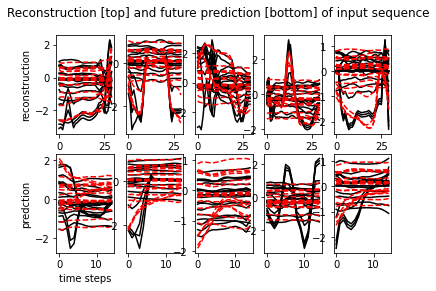

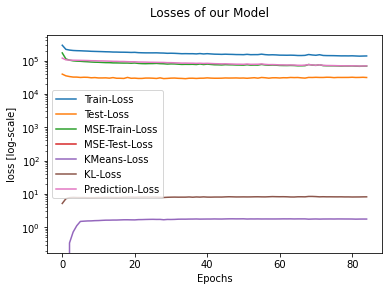

In [5]:
# Evaluate the network

vame.evaluate_model(config)

In [6]:
%%time
# Segment behavior

# vame.behavior_segmentation(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=[30])
vame.pose_segmentation(config)

Pose segmentation for VAME model: VAME 



  0%|                                                                                                                                                                                                            | 0/1715 [00:00<?, ?it/s]

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti
Load model... 
Embedd latent vector for file 11_12_2019_16_41_32_miniscope_DG_190806_a_succ_nofluobadtrigger


  2%|████                                                                                                                                                                                              | 36/1715 [00:00<00:04, 355.75it/s]

Embedd latent vector for file 08_18_2020_16_15_09_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 507.10it/s]

Embedd latent vector for file 09_05_2020_15_50_02_miniscope_DG_200701_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 573.68it/s]

Embedd latent vector for file 05_04_2021_09_46_01_miniscope_DG_210202_a_succ_head


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 533.32it/s]

Embedd latent vector for file 04_16_2021_08_37_19_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 487.64it/s]

Embedd latent vector for file 08_21_2020_16_08_48_miniscope_DG_200617_b_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:04, 416.69it/s]

Embedd latent vector for file 03_29_2021_10_13_07_miniscope_DG_210202_a_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 622.62it/s]

Embedd latent vector for file 09_02_2020_17_21_30_miniscope_DG_200617_b_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 469.07it/s]

Embedd latent vector for file 09_08_2020_15_47_44_miniscope_DG_200617_b_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 445.62it/s]

Embedd latent vector for file 04_08_2021_09_51_05_miniscope_DG_210202_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 459.39it/s]

Embedd latent vector for file 03_12_2020_16_23_09_miniscope_MM_200129_a_succ


  7%|█████████████▎                                                                                                                                                                                   | 118/1715 [00:00<00:02, 563.24it/s]

Embedd latent vector for file 08_13_2020_15_49_59_miniscope_DG_200701_a_succ_injured


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 468.58it/s]

Embedd latent vector for file 12_07_2019_16_05_30_miniscope_MM_191105_a_succ_nomini


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 579.38it/s]

Embedd latent vector for file 11_25_2019_14_55_06_miniscope_MM_191105_a_fail_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:02, 556.51it/s]

Embedd latent vector for file 04_23_2021_07_11_50_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 549.36it/s]

Embedd latent vector for file 08_06_2020_18_42_09_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 529.33it/s]

Embedd latent vector for file 08_07_2020_16_16_35_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 515.56it/s]

Embedd latent vector for file 03_26_2021_08_45_47_miniscope_DG_210202_a_fail_nonres_attempts


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 480.19it/s]

Embedd latent vector for file 03_30_2021_09_46_33_miniscope_DG_210202_a_succ_injured


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 476.25it/s]

Embedd latent vector for file 04_07_2021_09_50_25_miniscope_DG_210202_a_succ_firsthead


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 449.08it/s]

Embedd latent vector for file 12_11_2019_17_09_52_miniscope_MM_191108_a_succ


  3%|████▊                                                                                                                                                                                             | 43/1715 [00:00<00:03, 418.56it/s]

Embedd latent vector for file 11_29_2019_15_56_39_miniscope_MM_191108_a_fail_nomini


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 526.64it/s]

Embedd latent vector for file 08_10_2020_16_44_58_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:02, 554.62it/s]

Embedd latent vector for file 04_05_2021_10_38_41_miniscope_DG_210202_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 444.30it/s]

Embedd latent vector for file 04_13_2021_09_28_41_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 465.13it/s]

Embedd latent vector for file 09_06_2020_15_38_32_miniscope_DG_200617_b_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 456.26it/s]

Embedd latent vector for file 08_16_2020_16_15_42_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 524.40it/s]

Embedd latent vector for file 08_30_2020_15_47_33_miniscope_DG_200701_a_succ_injured


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 437.67it/s]

Embedd latent vector for file 08_14_2020_15_21_09_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 581.25it/s]

Embedd latent vector for file 08_09_2020_16_23_45_miniscope_DG_200617_b_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 619.81it/s]

Embedd latent vector for file 12_09_2019_15_25_14_miniscope_MM_191108_a_succ


  7%|████████████▋                                                                                                                                                                                    | 113/1715 [00:00<00:02, 563.27it/s]

Embedd latent vector for file 08_18_2020_16_01_32_miniscope_DG_200701_a_succ_injured


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 544.66it/s]

Embedd latent vector for file 03_10_2020_15_52_35_miniscope_MM_200129_a_succ


  7%|████████████▊                                                                                                                                                                                    | 114/1715 [00:00<00:02, 568.45it/s]

Embedd latent vector for file 08_16_2020_15_41_26_miniscope_DG_200701_a_succ_injured


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:03, 435.19it/s]

Embedd latent vector for file 12_10_2019_15_39_55_miniscope_MM_191108_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 585.19it/s]

Embedd latent vector for file 03_30_2021_09_33_30_miniscope_DG_210202_a_succ_injured


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 378.35it/s]

Embedd latent vector for file 04_13_2021_09_20_05_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 466.41it/s]

Embedd latent vector for file 03_26_2021_08_38_53_miniscope_DG_210202_a_fail_nonres_attempts


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 620.22it/s]

Embedd latent vector for file 03_05_2020_16_13_46_miniscope_MM_200129_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 456.01it/s]

Embedd latent vector for file 08_14_2020_15_40_19_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 505.68it/s]

Embedd latent vector for file 03_13_2020_13_53_47_miniscope_MM_200129_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 622.06it/s]

Embedd latent vector for file 08_10_2020_16_41_32_miniscope_DG_200701_a_succ


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:04, 404.87it/s]

Embedd latent vector for file 08_16_2020_15_56_30_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 507.29it/s]

Embedd latent vector for file 08_05_2020_16_06_18_miniscope_DG_200617_b_succ_earlystop


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:02, 569.09it/s]

Embedd latent vector for file 03_04_2020_16_18_47_miniscope_MM_200129_b_succ


  2%|████▍                                                                                                                                                                                             | 39/1715 [00:00<00:04, 378.42it/s]

Embedd latent vector for file 08_14_2020_15_37_49_miniscope_DG_200617_b_succ_injured


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 458.47it/s]

Embedd latent vector for file 05_03_2021_09_39_27_miniscope_DG_210202_a_succ_head


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 645.30it/s]

Embedd latent vector for file 12_04_2019_16_39_29_miniscope_MM_191105_a_succ_nomini


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 570.97it/s]

Embedd latent vector for file 12_06_2019_14_07_11_miniscope_MM_191105_a_succ_nomini


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 417.95it/s]

Embedd latent vector for file 08_29_2020_16_26_47_miniscope_DG_200617_b_succ


  6%|████████████▏                                                                                                                                                                                    | 108/1715 [00:00<00:03, 514.15it/s]

Embedd latent vector for file 11_26_2019_16_54_02_miniscope_MM_191108_a_fail_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 546.14it/s]

Embedd latent vector for file 11_29_2019_14_57_47_miniscope_MM_191106_a_fail_nomini


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:03, 424.03it/s]

Embedd latent vector for file 09_07_2020_14_59_11_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 509.51it/s]

Embedd latent vector for file 09_07_2020_15_38_41_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 439.77it/s]

Embedd latent vector for file 03_02_2020_15_54_55_miniscope_MM_200129_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 458.03it/s]

Embedd latent vector for file 04_02_2021_10_25_41_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 570.10it/s]

Embedd latent vector for file 08_14_2020_15_28_27_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 526.85it/s]

Embedd latent vector for file 04_23_2021_07_14_57_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 543.15it/s]

Embedd latent vector for file 11_26_2019_15_44_01_miniscope_MM_191106_a_fail_nomini


  6%|████████████▍                                                                                                                                                                                    | 111/1715 [00:00<00:02, 549.61it/s]

Embedd latent vector for file 03_13_2020_13_49_34_miniscope_MM_200129_b_succ


  3%|████▊                                                                                                                                                                                             | 43/1715 [00:00<00:03, 426.88it/s]

Embedd latent vector for file 08_15_2020_16_31_30_miniscope_DG_200617_b_succ_nofluo


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 456.66it/s]

Embedd latent vector for file 03_25_2021_09_45_37_miniscope_DG_210202_a_fail_nonres_attempts


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 452.19it/s]

Embedd latent vector for file 12_12_2019_15_00_56_miniscope_MM_191108_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 452.17it/s]

Embedd latent vector for file 08_15_2020_16_05_59_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 515.94it/s]

Embedd latent vector for file 04_08_2021_10_06_22_miniscope_DG_210202_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 496.47it/s]

Embedd latent vector for file 11_13_2019_18_19_35_miniscope_DG_190810_a_succ_nomini


  5%|██████████▏                                                                                                                                                                                       | 90/1715 [00:00<00:03, 439.06it/s]

Embedd latent vector for file 03_02_2020_15_50_05_miniscope_MM_200129_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 615.50it/s]

Embedd latent vector for file 12_07_2019_15_29_41_miniscope_MM_191108_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 486.43it/s]

Embedd latent vector for file 09_02_2020_17_32_19_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 579.96it/s]

Embedd latent vector for file 08_07_2020_16_13_27_miniscope_DG_200701_a_succ


  2%|████▍                                                                                                                                                                                             | 39/1715 [00:00<00:04, 389.24it/s]

Embedd latent vector for file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 442.04it/s]

Embedd latent vector for file 09_03_2020_16_36_15_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 544.69it/s]

Embedd latent vector for file 12_09_2019_17_01_33_miniscope_MM_191107_a_succ_bad_track_nomini


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 495.07it/s]

Embedd latent vector for file 04_21_2021_15_15_12_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 473.05it/s]

Embedd latent vector for file 08_31_2020_16_26_28_miniscope_DG_200617_b_succ


  2%|████                                                                                                                                                                                              | 36/1715 [00:00<00:05, 329.52it/s]

Embedd latent vector for file 11_29_2019_14_25_32_miniscope_MM_191105_a_fail_nomini


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 547.29it/s]

Embedd latent vector for file 04_26_2021_09_25_07_miniscope_DG_210202_a_succ


  3%|████▊                                                                                                                                                                                             | 43/1715 [00:00<00:03, 426.49it/s]

Embedd latent vector for file 09_06_2020_15_31_55_miniscope_DG_200617_b_succ


  7%|██████████████▏                                                                                                                                                                                  | 126/1715 [00:00<00:02, 610.04it/s]

Embedd latent vector for file 12_02_2019_16_13_23_miniscope_MM_191105_a_fail_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.02it/s]

Embedd latent vector for file 12_04_2019_15_52_05_miniscope_MM_191107_a_succ_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.50it/s]

Embedd latent vector for file 08_17_2020_15_50_49_miniscope_DG_200701_a_succ_injured


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 04_27_2021_09_50_05_miniscope_DG_210202_a_succ_head


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.27it/s]

Embedd latent vector for file 11_25_2019_15_09_04_miniscope_MM_191106_a_fail_nomini


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 447.69it/s]

Embedd latent vector for file 11_29_2019_15_23_26_miniscope_MM_191107_a_fail_nomini


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.82it/s]

Embedd latent vector for file 03_04_2020_16_16_18_miniscope_MM_200129_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.39it/s]

Embedd latent vector for file 12_07_2019_15_11_16_miniscope_MM_191108_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.15it/s]

Embedd latent vector for file 04_29_2021_07_49_17_miniscope_DG_210202_a_succ_head


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 588.21it/s]

Embedd latent vector for file 04_12_2021_09_34_13_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 584.95it/s]

Embedd latent vector for file 08_21_2020_15_36_39_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 537.79it/s]

Embedd latent vector for file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 493.28it/s]

Embedd latent vector for file 09_07_2020_15_18_17_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 482.01it/s]

Embedd latent vector for file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 495.91it/s]

Embedd latent vector for file 12_07_2019_15_43_37_miniscope_MM_191108_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.38it/s]

Embedd latent vector for file 11_12_2019_17_07_21_miniscope_DG_190810_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.53it/s]

Embedd latent vector for file 08_16_2020_16_18_28_miniscope_DG_200617_b_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.67it/s]

Embedd latent vector for file 08_13_2020_15_45_14_miniscope_DG_200701_a_succ_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.24it/s]

Embedd latent vector for file 08_19_2020_16_52_39_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 08_11_2020_15_25_00_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 09_04_2020_16_43_01_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.58it/s]

Embedd latent vector for file 08_29_2020_16_33_45_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.26it/s]

Embedd latent vector for file 04_01_2021_09_43_29_miniscope_DG_210202_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.24it/s]

Embedd latent vector for file 12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:03, 437.58it/s]

Embedd latent vector for file 08_12_2020_16_17_05_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 03_31_2021_09_19_18_miniscope_DG_210202_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 03_31_2021_09_45_11_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 08_09_2020_15_05_48_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 12_10_2019_15_35_36_miniscope_MM_191108_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.25it/s]

Embedd latent vector for file 04_29_2021_07_36_15_miniscope_DG_210202_a_succ_head


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 444.35it/s]

Embedd latent vector for file 03_29_2021_09_17_07_miniscope_DG_210202_a_succ


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 365.78it/s]

Embedd latent vector for file 12_11_2019_17_05_25_miniscope_MM_191108_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 12_09_2019_16_38_36_miniscope_MM_191105_a_succ_nomini


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 408.95it/s]

Embedd latent vector for file 08_06_2020_17_33_37_miniscope_DG_200701_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 575.19it/s]

Embedd latent vector for file 04_30_2021_10_16_01_miniscope_DG_210202_a_succ_head


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 508.20it/s]

Embedd latent vector for file 03_31_2021_09_32_31_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.71it/s]

Embedd latent vector for file 11_12_2019_16_47_36_miniscope_DG_190806_a_succ_nofluo


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.84it/s]

Embedd latent vector for file 04_06_2021_09_47_18_miniscope_DG_210202_a_succ_injured


  4%|███████▌                                                                                                                                                                                          | 67/1715 [00:00<00:02, 592.76it/s]

Embedd latent vector for file 08_17_2020_16_16_18_miniscope_DG_200617_b_succ


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 384.10it/s]

Embedd latent vector for file 09_03_2020_16_47_03_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.51it/s]

Embedd latent vector for file 03_02_2020_16_29_48_miniscope_MM_200129_b_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.40it/s]

Embedd latent vector for file 09_01_2020_16_17_14_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 519.29it/s]

Embedd latent vector for file 09_03_2020_15_59_43_miniscope_DG_200701_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 497.22it/s]

Embedd latent vector for file 11_11_2019_23_35_36_miniscope_DG_190810_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 12_02_2019_16_52_33_miniscope_MM_191106_a_fail_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 593.28it/s]

Embedd latent vector for file 12_03_2019_15_15_55_miniscope_MM_191105_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 08_05_2020_16_20_09_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.24it/s]

Embedd latent vector for file 04_13_2021_09_25_19_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.67it/s]

Embedd latent vector for file 08_11_2020_15_51_51_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.25it/s]

Embedd latent vector for file 08_16_2020_16_04_28_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_29_2021_07_42_42_miniscope_DG_210202_a_succ_head


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.49it/s]

Embedd latent vector for file 09_01_2020_16_39_52_miniscope_DG_200617_b_succ_injured


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 09_05_2020_16_23_03_miniscope_DG_200617_b_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 410.19it/s]

Embedd latent vector for file 08_31_2020_15_46_43_miniscope_DG_200701_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 432.34it/s]

Embedd latent vector for file 03_02_2020_16_20_39_miniscope_MM_200129_b_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.26it/s]

Embedd latent vector for file 12_04_2019_15_19_29_miniscope_MM_191106_a_succ_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini


  2%|████▍                                                                                                                                                                                             | 39/1715 [00:00<00:04, 356.64it/s]

Embedd latent vector for file 09_05_2020_15_40_48_miniscope_DG_200701_a_succ_injured


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 08_06_2020_18_02_17_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.12it/s]

Embedd latent vector for file 08_10_2020_16_52_15_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 12_03_2019_16_20_45_miniscope_MM_191106_a_fail_nomini


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 565.14it/s]

Embedd latent vector for file 11_14_2019_17_15_24_miniscope_DG_190806_a_succ_nofluo


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:02, 560.49it/s]

Embedd latent vector for file 04_14_2021_12_56_11_miniscope_DG_210202_a_succ_noncon


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 388.63it/s]

Embedd latent vector for file 04_09_2021_07_04_10_miniscope_DG_210202_a_succ_injured


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 382.83it/s]

Embedd latent vector for file 04_26_2021_09_41_15_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 497.59it/s]

Embedd latent vector for file 05_04_2021_09_37_07_miniscope_DG_210202_a_succ_head


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.67it/s]

Embedd latent vector for file 04_09_2021_07_11_46_miniscope_DG_210202_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 565.12it/s]

Embedd latent vector for file 05_06_2021_09_24_55_miniscope_DG_210202_a_succ_head


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 566.99it/s]

Embedd latent vector for file 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 11_29_2019_14_50_39_miniscope_MM_191106_a_fail_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.50it/s]

Embedd latent vector for file 04_09_2021_07_07_05_miniscope_DG_210202_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 455.76it/s]

Embedd latent vector for file 09_07_2020_14_51_32_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.39it/s]

Embedd latent vector for file 04_26_2021_09_46_03_miniscope_DG_210202_a_succ


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:03, 437.35it/s]

Embedd latent vector for file 12_16_2019_16_21_34_miniscope_MM_191108_a_fail


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 565.12it/s]

Embedd latent vector for file 09_01_2020_16_47_10_miniscope_DG_200617_b_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 504.65it/s]

Embedd latent vector for file 08_10_2020_17_33_00_miniscope_DG_200617_b_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 504.53it/s]

Embedd latent vector for file 08_29_2020_16_08_29_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 510.51it/s]

Embedd latent vector for file 08_29_2020_16_54_07_miniscope_DG_200617_b_succ_nofluo


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 441.83it/s]

Embedd latent vector for file 04_16_2021_08_42_50_miniscope_DG_210202_a_succ_headfirst


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.55it/s]

Embedd latent vector for file 05_04_2021_09_32_08_miniscope_DG_210202_a_succ_head


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:02, 581.11it/s]

Embedd latent vector for file 11_13_2019_18_23_01_miniscope_DG_190810_a_succ_nomini


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 419.29it/s]

Embedd latent vector for file 08_20_2020_15_51_33_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.19it/s]

Embedd latent vector for file 03_12_2020_16_56_04_miniscope_MM_200129_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.23it/s]

Embedd latent vector for file 08_14_2020_15_54_58_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.35it/s]

Embedd latent vector for file 12_04_2019_15_23_56_miniscope_MM_191106_a_succ_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.08it/s]

Embedd latent vector for file 08_17_2020_16_10_15_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 464.76it/s]

Embedd latent vector for file 05_06_2021_09_44_17_miniscope_DG_210202_a_succ_head


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 638.58it/s]

Embedd latent vector for file 04_08_2021_10_02_04_miniscope_DG_210202_a_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 593.92it/s]

Embedd latent vector for file 05_04_2021_09_14_43_miniscope_DG_210202_a_succ_head_nofluo


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 587.77it/s]

Embedd latent vector for file 09_01_2020_16_55_25_miniscope_DG_200617_b_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 436.90it/s]

Embedd latent vector for file 08_20_2020_16_40_35_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.57it/s]

Embedd latent vector for file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 420.64it/s]

Embedd latent vector for file 12_10_2019_16_57_26_miniscope_MM_191107_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.30it/s]

Embedd latent vector for file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 494.49it/s]

Embedd latent vector for file 04_07_2021_10_11_16_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 588.14it/s]

Embedd latent vector for file 12_06_2019_14_55_56_miniscope_MM_191106_a_succ_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 504.62it/s]

Embedd latent vector for file 09_06_2020_15_43_13_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_15_2021_10_37_06_miniscope_DG_210202_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.71it/s]

Embedd latent vector for file 03_04_2020_16_12_03_miniscope_MM_200129_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 09_03_2020_15_54_14_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.29it/s]

Embedd latent vector for file 08_08_2020_16_12_42_miniscope_DG_200617_b_succ_noncon


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 593.77it/s]

Embedd latent vector for file 05_03_2021_09_43_13_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.29it/s]

Embedd latent vector for file 03_12_2020_16_32_46_miniscope_MM_200129_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.54it/s]

Embedd latent vector for file 04_27_2021_09_46_57_miniscope_DG_210202_a_succ_head


  2%|████▎                                                                                                                                                                                             | 38/1715 [00:00<00:04, 363.52it/s]

Embedd latent vector for file 04_22_2021_09_13_20_miniscope_DG_210202_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 539.17it/s]

Embedd latent vector for file 08_09_2020_16_03_39_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 08_30_2020_16_28_07_miniscope_DG_200617_b_succ


  4%|███████▌                                                                                                                                                                                          | 67/1715 [00:00<00:02, 599.01it/s]

Embedd latent vector for file 03_12_2020_16_30_37_miniscope_MM_200129_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 618.25it/s]

Embedd latent vector for file 03_05_2020_15_35_45_miniscope_MM_200129_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 08_19_2020_16_05_59_miniscope_DG_200701_a_succ_grabbedcable


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.04it/s]

Embedd latent vector for file 08_07_2020_17_08_34_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.56it/s]

Embedd latent vector for file 08_17_2020_15_36_48_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 12_04_2019_16_07_38_miniscope_MM_191108_a_succ_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 08_07_2020_16_21_53_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.10it/s]

Embedd latent vector for file 08_11_2020_15_47_26_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.35it/s]

Embedd latent vector for file 08_19_2020_15_51_39_miniscope_DG_200701_a_succ_injured


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.55it/s]

Embedd latent vector for file 08_09_2020_14_55_56_miniscope_DG_200701_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.52it/s]

Embedd latent vector for file 12_09_2019_17_04_36_miniscope_MM_191107_a_succ_nomini


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.24it/s]

Embedd latent vector for file 09_05_2020_15_52_46_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 09_01_2020_15_56_27_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 04_30_2021_09_56_07_miniscope_DG_210202_a_succ_head


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.36it/s]

Embedd latent vector for file 08_07_2020_16_08_55_miniscope_DG_200701_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 535.70it/s]

Embedd latent vector for file 08_31_2020_15_59_34_miniscope_DG_200701_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 429.82it/s]

Embedd latent vector for file 08_06_2020_18_24_41_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 05_04_2021_09_48_58_miniscope_DG_210202_a_succ_head


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 419.30it/s]

Embedd latent vector for file 11_12_2019_16_54_56_miniscope_DG_190806_a_succ_nofluo


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 12_02_2019_16_27_33_miniscope_MM_191105_a_fail_nomini


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 489.89it/s]

Embedd latent vector for file 05_05_2021_09_26_05_miniscope_DG_210202_a_succ_head


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.74it/s]

Embedd latent vector for file 04_22_2021_09_44_38_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 479.70it/s]

Embedd latent vector for file 05_06_2021_09_38_47_miniscope_DG_210202_a_succ_head_injured


  4%|███████▌                                                                                                                                                                                          | 67/1715 [00:00<00:02, 584.22it/s]

Embedd latent vector for file 08_11_2020_15_22_04_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 514.38it/s]

Embedd latent vector for file 04_02_2021_10_03_36_miniscope_DG_210202_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 562.46it/s]

Embedd latent vector for file 11_29_2019_15_49_40_miniscope_MM_191108_a_fail_nomini


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 439.00it/s]

Embedd latent vector for file 03_13_2020_13_25_36_miniscope_MM_200129_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 537.82it/s]

Embedd latent vector for file 12_02_2019_17_08_58_miniscope_MM_191107_a_succ_nomini


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:03, 549.87it/s]

Embedd latent vector for file 12_07_2019_16_18_20_miniscope_MM_191106_a_succ_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 578.51it/s]

Embedd latent vector for file 05_04_2021_09_21_59_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 03_11_2020_16_14_11_miniscope_MM_200129_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.50it/s]

Embedd latent vector for file 08_21_2020_15_32_26_miniscope_DG_200701_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.55it/s]

Embedd latent vector for file 03_25_2021_09_36_59_miniscope_DG_210202_a_fail_nonres_attempts


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 502.45it/s]

Embedd latent vector for file 08_06_2020_17_58_44_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.56it/s]

Embedd latent vector for file 03_31_2021_09_49_31_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 03_06_2020_16_20_40_miniscope_MM_200129_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 04_14_2021_12_49_53_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.46it/s]

Embedd latent vector for file 08_29_2020_16_15_31_miniscope_DG_200701_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.83it/s]

Embedd latent vector for file 04_16_2021_08_47_55_miniscope_DG_210202_a_succ_latestop


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.10it/s]

Embedd latent vector for file 09_08_2020_15_39_45_miniscope_DG_200617_b_succ


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:03, 438.34it/s]

Embedd latent vector for file 04_15_2021_10_19_39_miniscope_DG_210202_a_succ


  4%|███████▌                                                                                                                                                                                          | 67/1715 [00:00<00:02, 591.70it/s]

Embedd latent vector for file 08_06_2020_17_47_03_miniscope_DG_200701_a_fail


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.36it/s]

Embedd latent vector for file 12_10_2019_15_00_45_miniscope_MM_191108_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 492.11it/s]

Embedd latent vector for file 03_11_2020_16_52_20_miniscope_MM_200129_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.35it/s]

Embedd latent vector for file 08_11_2020_15_31_17_miniscope_DG_200701_a_succ_injured


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.10it/s]

Embedd latent vector for file 08_11_2020_15_33_47_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.23it/s]

Embedd latent vector for file 04_13_2021_09_35_19_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 504.27it/s]

Embedd latent vector for file 11_29_2019_14_09_23_miniscope_MM_191105_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 12_03_2019_15_47_19_miniscope_MM_191107_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.14it/s]

Embedd latent vector for file 03_06_2020_16_00_37_miniscope_MM_200129_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.83it/s]

Embedd latent vector for file 12_12_2019_15_16_04_miniscope_MM_191108_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.11it/s]

Embedd latent vector for file 11_25_2019_15_22_31_miniscope_MM_191106_a_fail_nomini


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 535.48it/s]

Embedd latent vector for file 08_10_2020_16_56_35_miniscope_DG_200701_a_succ_injured


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.29it/s]

Embedd latent vector for file 12_06_2019_15_04_44_miniscope_MM_191107_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.14it/s]

Embedd latent vector for file 11_26_2019_16_39_57_miniscope_MM_191107_a_fail_nomini


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:04, 401.07it/s]

Embedd latent vector for file 03_11_2020_16_47_49_miniscope_MM_200129_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.99it/s]

Embedd latent vector for file 08_31_2020_16_29_59_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 04_14_2021_12_58_11_miniscope_DG_210202_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.90it/s]

Embedd latent vector for file 08_16_2020_16_27_15_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.49it/s]

Embedd latent vector for file 03_13_2020_13_20_21_miniscope_MM_200129_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 576.29it/s]

Embedd latent vector for file 08_31_2020_16_42_25_miniscope_DG_200617_b_succ_injured


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.95it/s]

Embedd latent vector for file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini


  2%|████▎                                                                                                                                                                                             | 38/1715 [00:00<00:04, 347.52it/s]

Embedd latent vector for file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.70it/s]

Embedd latent vector for file 08_14_2020_15_44_42_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.55it/s]

Embedd latent vector for file 03_11_2020_15_58_51_miniscope_MM_200129_a_succ


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 364.60it/s]

Embedd latent vector for file 12_09_2019_15_16_05_miniscope_MM_191108_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 573.16it/s]

Embedd latent vector for file 11_25_2019_16_15_54_miniscope_MM_191108_a_fail_nomini


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 493.07it/s]

Embedd latent vector for file 08_06_2020_18_50_24_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 582.61it/s]

Embedd latent vector for file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.35it/s]

Embedd latent vector for file 11_25_2019_16_22_23_miniscope_MM_191108_a_fail_nomini


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.92it/s]

Embedd latent vector for file 11_13_2019_17_57_10_miniscope_DG_190806_a_succ_nofluobadtrigger


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 581.90it/s]

Embedd latent vector for file 08_30_2020_15_44_44_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 584.09it/s]

Embedd latent vector for file 08_21_2020_16_18_56_miniscope_DG_200617_b_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 587.68it/s]

Embedd latent vector for file 08_08_2020_15_30_48_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.36it/s]

Embedd latent vector for file 05_05_2021_09_39_47_miniscope_DG_210202_a_succ_head


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 410.21it/s]

Embedd latent vector for file 04_23_2021_07_27_39_miniscope_DG_210202_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.94it/s]

Embedd latent vector for file 11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 456.11it/s]

Embedd latent vector for file 08_29_2020_16_17_59_miniscope_DG_200701_a_succ


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:04, 402.36it/s]

Embedd latent vector for file 08_30_2020_16_35_54_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.49it/s]

Embedd latent vector for file 08_10_2020_16_48_58_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.49it/s]

Embedd latent vector for file 12_02_2019_16_58_55_miniscope_MM_191106_a_fail_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 08_18_2020_16_34_54_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 483.10it/s]

Embedd latent vector for file 04_05_2021_10_22_15_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 428.43it/s]

Embedd latent vector for file 03_04_2020_15_46_47_miniscope_MM_200129_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.30it/s]

Embedd latent vector for file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 09_05_2020_16_09_14_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.36it/s]

Embedd latent vector for file 04_12_2021_09_31_13_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.56it/s]

Embedd latent vector for file 12_02_2019_17_44_49_miniscope_MM_191108_a_fail_nomini


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 540.90it/s]

Embedd latent vector for file 08_31_2020_16_32_34_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 534.78it/s]

Embedd latent vector for file 04_06_2021_10_09_13_miniscope_DG_210202_a_succ_injured


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 502.96it/s]

Embedd latent vector for file 09_06_2020_15_05_22_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 489.42it/s]

Embedd latent vector for file 12_04_2019_16_27_21_miniscope_MM_191108_a_succ_nomini


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 571.87it/s]

Embedd latent vector for file 04_27_2021_09_37_28_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.11it/s]

Embedd latent vector for file 08_07_2020_16_43_52_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 537.81it/s]

Embedd latent vector for file 09_03_2020_16_43_43_miniscope_DG_200617_b_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 461.50it/s]

Embedd latent vector for file 09_02_2020_17_27_37_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 08_31_2020_16_10_12_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 08_16_2020_15_50_17_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.00it/s]

Embedd latent vector for file 08_06_2020_18_07_32_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 513.15it/s]

Embedd latent vector for file 03_06_2020_15_53_37_miniscope_MM_200129_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 420.67it/s]

Embedd latent vector for file 09_05_2020_15_45_35_miniscope_DG_200701_a_succ_injured


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.40it/s]

Embedd latent vector for file 04_06_2021_09_40_26_miniscope_DG_210202_a_succ_injured


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 587.19it/s]

Embedd latent vector for file 08_16_2020_15_43_35_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 505.84it/s]

Embedd latent vector for file 04_13_2021_09_22_44_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.15it/s]

Embedd latent vector for file 12_07_2019_16_34_28_miniscope_MM_191107_a_succ_nomini


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.96it/s]

Embedd latent vector for file 12_06_2019_14_50_58_miniscope_MM_191106_a_succ_nomini


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 460.99it/s]

Embedd latent vector for file 09_03_2020_16_06_54_miniscope_DG_200701_a_succ_injured


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 477.09it/s]

Embedd latent vector for file 04_01_2021_09_38_38_miniscope_DG_210202_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.51it/s]

Embedd latent vector for file 08_05_2020_15_29_56_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.40it/s]

Embedd latent vector for file 08_09_2020_15_57_15_miniscope_DG_200617_b_succ


  2%|███▋                                                                                                                                                                                              | 33/1715 [00:00<00:05, 301.80it/s]

Embedd latent vector for file 09_04_2020_17_14_08_miniscope_DG_200617_b_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.96it/s]

Embedd latent vector for file 08_15_2020_16_02_16_miniscope_DG_200701_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 534.13it/s]

Embedd latent vector for file 08_21_2020_15_42_56_miniscope_DG_200701_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 550.50it/s]

Embedd latent vector for file 09_06_2020_15_47_33_miniscope_DG_200617_b_succ_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 578.06it/s]

Embedd latent vector for file 11_26_2019_15_52_26_miniscope_MM_191106_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 09_07_2020_14_42_14_miniscope_DG_200701_a_succ_injured


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 08_11_2020_15_12_33_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:02, 569.32it/s]

Embedd latent vector for file 03_26_2021_08_53_20_miniscope_DG_210202_a_fail_nonres_attempts


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 485.86it/s]

Embedd latent vector for file 12_03_2019_15_00_53_miniscope_MM_191105_a_fail_nomini


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.56it/s]

Embedd latent vector for file 08_30_2020_16_14_23_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.26it/s]

Embedd latent vector for file 09_03_2020_16_12_49_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.10it/s]

Embedd latent vector for file 08_14_2020_15_07_03_miniscope_DG_200701_a_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 601.57it/s]

Embedd latent vector for file 09_08_2020_15_20_34_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.01it/s]

Embedd latent vector for file 12_10_2019_15_30_07_miniscope_MM_191108_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 446.62it/s]

Embedd latent vector for file 12_06_2019_15_13_44_miniscope_MM_191107_a_succ_nomini


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.70it/s]

Embedd latent vector for file 08_30_2020_15_59_37_miniscope_DG_200701_a_succ_injured


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.41it/s]

Embedd latent vector for file 03_04_2020_15_37_26_miniscope_MM_200129_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.45it/s]

Embedd latent vector for file 08_29_2020_16_01_17_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 495.68it/s]

Embedd latent vector for file 11_29_2019_14_16_30_miniscope_MM_191105_a_fail_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.33it/s]

Embedd latent vector for file 04_22_2021_09_26_54_miniscope_DG_210202_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 538.95it/s]

Embedd latent vector for file 08_19_2020_16_16_55_miniscope_DG_200701_a_succ_noncon


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.53it/s]

Embedd latent vector for file 08_08_2020_16_08_14_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_01_2021_09_47_53_miniscope_DG_210202_a_succ


  2%|████▍                                                                                                                                                                                             | 39/1715 [00:00<00:04, 356.66it/s]

Embedd latent vector for file 04_14_2021_12_40_17_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 03_11_2020_16_10_08_miniscope_MM_200129_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.98it/s]

Embedd latent vector for file 09_01_2020_16_43_46_miniscope_DG_200617_b_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.74it/s]

Embedd latent vector for file 03_29_2021_10_04_21_miniscope_DG_210202_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.74it/s]

Embedd latent vector for file 03_26_2021_09_00_53_miniscope_DG_210202_a_fail_nonres_attempts


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.25it/s]

Embedd latent vector for file 08_09_2020_14_53_16_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 08_16_2020_15_52_46_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.14it/s]

Embedd latent vector for file 03_31_2021_09_23_53_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 436.09it/s]

Embedd latent vector for file 08_18_2020_15_54_55_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.74it/s]

Embedd latent vector for file 04_21_2021_15_25_58_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.53it/s]

Embedd latent vector for file 08_07_2020_16_28_48_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.12it/s]

Embedd latent vector for file 11_25_2019_14_30_43_miniscope_MM_191105_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 08_09_2020_16_13_20_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.24it/s]

Embedd latent vector for file 11_13_2019_18_14_36_miniscope_DG_190810_a_succ_nomini


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 446.65it/s]

Embedd latent vector for file 08_15_2020_15_45_13_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.46it/s]

Embedd latent vector for file 09_02_2020_16_50_16_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.39it/s]

Embedd latent vector for file 11_12_2019_17_02_59_miniscope_DG_190810_a_succ_nomini


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 471.35it/s]

Embedd latent vector for file 09_07_2020_15_41_46_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 04_15_2021_10_22_42_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.29it/s]

Embedd latent vector for file 08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured


  3%|████▉                                                                                                                                                                                             | 44/1715 [00:00<00:04, 402.38it/s]

Embedd latent vector for file 05_03_2021_09_35_13_miniscope_DG_210202_a_succ_head


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.98it/s]

Embedd latent vector for file 04_22_2021_09_30_14_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.54it/s]

Embedd latent vector for file 09_02_2020_17_35_23_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.29it/s]

Embedd latent vector for file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.26it/s]

Embedd latent vector for file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 496.67it/s]

Embedd latent vector for file 03_06_2020_16_25_04_miniscope_MM_200129_b_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.99it/s]

Embedd latent vector for file 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.75it/s]

Embedd latent vector for file 08_17_2020_15_38_44_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 08_13_2020_16_32_11_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.44it/s]

Embedd latent vector for file 08_13_2020_15_39_43_miniscope_DG_200701_a_succ_movecam


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.96it/s]

Embedd latent vector for file 04_14_2021_12_43_23_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.11it/s]

Embedd latent vector for file 04_21_2021_15_38_42_miniscope_DG_210202_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.97it/s]

Embedd latent vector for file 04_02_2021_10_30_38_miniscope_DG_210202_a_succ


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 416.09it/s]

Embedd latent vector for file 05_07_2021_09_42_55_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 584.79it/s]

Embedd latent vector for file 12_02_2019_16_21_09_miniscope_MM_191105_a_fail_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 04_23_2021_07_32_06_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 488.90it/s]

Embedd latent vector for file 05_05_2021_09_29_50_miniscope_DG_210202_a_succ_head


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 08_06_2020_17_54_57_miniscope_DG_200701_a_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.24it/s]

Embedd latent vector for file 03_12_2020_16_25_39_miniscope_MM_200129_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.81it/s]

Embedd latent vector for file 04_15_2021_10_26_27_miniscope_DG_210202_a_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 04_22_2021_09_18_21_miniscope_DG_210202_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 05_05_2021_09_43_26_miniscope_DG_210202_a_succ_head


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 03_10_2020_16_17_45_miniscope_MM_200129_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 522.52it/s]

Embedd latent vector for file 03_02_2020_16_15_37_miniscope_MM_200129_b_fail


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 530.41it/s]

Embedd latent vector for file 12_04_2019_16_53_11_miniscope_MM_191105_a_succ_nomini


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.83it/s]

Embedd latent vector for file 04_07_2021_10_15_35_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 437.23it/s]

Embedd latent vector for file 08_12_2020_15_47_44_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 03_24_2021_13_38_36_miniscope_DG_210202_a_fail_nonres


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 03_11_2020_16_37_26_miniscope_MM_200129_b_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 530.47it/s]

Embedd latent vector for file 04_06_2021_09_58_21_miniscope_DG_210202_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.56it/s]

Embedd latent vector for file 11_11_2019_23_23_16_miniscope_DG_190810_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.12it/s]

Embedd latent vector for file 04_21_2021_15_43_11_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 444.67it/s]

Embedd latent vector for file 08_13_2020_16_05_09_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 08_29_2020_16_38_23_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 09_02_2020_16_34_36_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.55it/s]

Embedd latent vector for file 04_27_2021_09_34_46_miniscope_DG_210202_a_succ_head


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.24it/s]

Embedd latent vector for file 04_05_2021_10_25_10_miniscope_DG_210202_a_succ_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 08_16_2020_16_07_07_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 395.16it/s]

Embedd latent vector for file 12_02_2019_16_05_42_miniscope_MM_191105_a_fail_nomini


  2%|████▏                                                                                                                                                                                             | 37/1715 [00:00<00:04, 335.69it/s]

Embedd latent vector for file 08_12_2020_15_35_36_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_12_2021_09_42_45_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 530.39it/s]

Embedd latent vector for file 11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.39it/s]

Embedd latent vector for file 04_05_2021_10_52_52_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.12it/s]

Embedd latent vector for file 08_18_2020_16_23_10_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 449.59it/s]

Embedd latent vector for file 08_08_2020_15_44_28_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 08_17_2020_15_34_07_miniscope_DG_200701_a_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.97it/s]

Embedd latent vector for file 12_16_2019_16_27_17_miniscope_MM_191108_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 530.38it/s]

Embedd latent vector for file 09_05_2020_15_42_56_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.10it/s]

Embedd latent vector for file 05_03_2021_09_30_47_miniscope_DG_210202_a_succ_head


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 04_16_2021_08_55_41_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 443.05it/s]

Embedd latent vector for file 12_03_2019_16_48_22_miniscope_MM_191108_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 08_29_2020_16_04_30_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 09_06_2020_15_28_50_miniscope_DG_200617_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.27it/s]

Embedd latent vector for file 12_09_2019_16_34_39_miniscope_MM_191105_a_succ_nomini


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 566.96it/s]

Embedd latent vector for file 08_30_2020_15_50_51_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 479.55it/s]

Embedd latent vector for file 03_02_2020_15_35_18_miniscope_MM_200129_a_succ_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 08_07_2020_16_48_37_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.94it/s]

Embedd latent vector for file 03_10_2020_16_21_31_miniscope_MM_200129_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 04_12_2021_09_27_00_miniscope_DG_210202_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.40it/s]

Embedd latent vector for file 11_11_2019_22_48_32_miniscope_DG_190806_a_fail_nofluo


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 03_02_2020_15_41_21_miniscope_MM_200129_a_succ_nomini


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 566.98it/s]

Embedd latent vector for file 09_07_2020_15_02_53_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 11_29_2019_15_16_19_miniscope_MM_191107_a_fail_nomini


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 449.57it/s]

Embedd latent vector for file 03_10_2020_16_09_06_miniscope_MM_200129_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_23_2021_07_07_28_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 12_09_2019_15_04_06_miniscope_MM_191108_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.10it/s]

Embedd latent vector for file 04_16_2021_08_53_00_miniscope_DG_210202_a_succ_droppedframes


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 566.99it/s]

Embedd latent vector for file 12_12_2019_15_18_57_miniscope_MM_191108_a_fail


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 528.14it/s]

Embedd latent vector for file 08_14_2020_15_34_20_miniscope_DG_200617_b_succ_injured


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 587.38it/s]

Embedd latent vector for file 04_14_2021_13_00_40_miniscope_DG_210202_a_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 602.24it/s]

Embedd latent vector for file 12_04_2019_16_18_37_miniscope_MM_191108_a_succ_nomini


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.24it/s]

Embedd latent vector for file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 612.26it/s]

Embedd latent vector for file 12_06_2019_14_21_20_miniscope_MM_191105_a_succ_nomini


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 488.28it/s]

Embedd latent vector for file 12_07_2019_15_01_31_miniscope_MM_191108_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 12_09_2019_15_34_10_miniscope_MM_191108_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 08_19_2020_15_55_28_miniscope_DG_200701_a_succ_injured


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 420.66it/s]

Embedd latent vector for file 08_18_2020_16_25_33_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.24it/s]

Embedd latent vector for file 04_30_2021_09_59_45_miniscope_DG_210202_a_succ_head


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 556.65it/s]

Embedd latent vector for file 08_07_2020_16_52_22_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 566.81it/s]

Embedd latent vector for file 04_01_2021_09_51_46_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.43it/s]

Embedd latent vector for file 08_18_2020_15_59_09_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.14it/s]

Embedd latent vector for file 08_08_2020_16_00_22_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 584.99it/s]

Embedd latent vector for file 04_02_2021_10_10_35_miniscope_DG_210202_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 514.17it/s]

Embedd latent vector for file 12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.55it/s]

Embedd latent vector for file 08_13_2020_15_55_14_miniscope_DG_200701_a_succ


  2%|████▍                                                                                                                                                                                             | 39/1715 [00:00<00:04, 357.84it/s]

Embedd latent vector for file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 03_02_2020_16_09_51_miniscope_MM_200129_b_fail


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 12_10_2019_15_15_08_miniscope_MM_191108_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_22_2021_09_21_54_miniscope_DG_210202_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.39it/s]

Embedd latent vector for file 11_29_2019_15_08_11_miniscope_MM_191107_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 558.16it/s]

Embedd latent vector for file 09_05_2020_16_19_09_miniscope_DG_200617_b_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 567.02it/s]

Embedd latent vector for file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.96it/s]

Embedd latent vector for file 12_09_2019_16_46_19_miniscope_MM_191106_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 586.08it/s]

Embedd latent vector for file 08_20_2020_15_43_36_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 11_26_2019_16_32_30_miniscope_MM_191107_a_fail_nomini


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.92it/s]

Embedd latent vector for file 05_07_2021_09_45_32_miniscope_DG_210202_a_succ_head


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 492.27it/s]

Embedd latent vector for file 05_04_2021_09_19_22_miniscope_DG_210202_a_succ_head


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.54it/s]

Embedd latent vector for file 12_10_2019_16_53_34_miniscope_MM_191107_a_succ_nomini


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 477.12it/s]

Embedd latent vector for file 03_05_2020_16_07_59_miniscope_MM_200129_b_succ


  2%|████▎                                                                                                                                                                                             | 38/1715 [00:00<00:04, 346.37it/s]

Embedd latent vector for file 05_07_2021_09_18_06_miniscope_DG_210202_a_succ_head


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 428.41it/s]

Embedd latent vector for file 08_11_2020_15_56_40_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 500.07it/s]

Embedd latent vector for file 09_07_2020_14_48_19_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.00it/s]

Embedd latent vector for file 12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:03, 449.74it/s]

Embedd latent vector for file 12_07_2019_15_06_28_miniscope_MM_191108_a_succ


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 363.51it/s]

Embedd latent vector for file 03_25_2021_09_29_46_miniscope_DG_210202_a_fail_nonres_attempts


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 09_06_2020_15_51_43_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 03_04_2020_15_42_07_miniscope_MM_200129_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 511.28it/s]

Embedd latent vector for file 09_05_2020_15_56_40_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.55it/s]

Embedd latent vector for file 08_14_2020_15_09_52_miniscope_DG_200701_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.70it/s]

Embedd latent vector for file 05_05_2021_09_33_14_miniscope_DG_210202_a_succ_head


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 12_09_2019_16_58_58_miniscope_MM_191107_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 03_29_2021_09_56_46_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 04_06_2021_10_05_46_miniscope_DG_210202_a_succ


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 367.03it/s]

Embedd latent vector for file 08_14_2020_15_23_43_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.55it/s]

Embedd latent vector for file 08_20_2020_15_48_39_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.53it/s]

Embedd latent vector for file 08_12_2020_16_21_45_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 08_12_2020_16_24_56_miniscope_DG_200617_b_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 419.47it/s]

Embedd latent vector for file 12_16_2019_16_31_08_miniscope_MM_191108_a_succ


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 375.92it/s]

Embedd latent vector for file 08_19_2020_16_09_08_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 493.15it/s]

Embedd latent vector for file 05_04_2021_09_40_04_miniscope_DG_210202_a_succ_head


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 05_07_2021_09_35_17_miniscope_DG_210202_a_succ_head


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.55it/s]

Embedd latent vector for file 11_14_2019_17_19_46_miniscope_DG_190806_a_succ_nofluo


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 365.80it/s]

Embedd latent vector for file 12_07_2019_15_34_47_miniscope_MM_191108_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 625.21it/s]

Embedd latent vector for file 08_10_2020_17_13_00_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 440.35it/s]

Embedd latent vector for file 08_13_2020_15_59_37_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 12_04_2019_16_01_30_miniscope_MM_191107_a_succ_nomini


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.67it/s]

Embedd latent vector for file 04_28_2021_09_38_10_miniscope_DG_210202_a_succ_head


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 440.42it/s]

Embedd latent vector for file 08_21_2020_16_24_35_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.25it/s]

Embedd latent vector for file 08_08_2020_15_57_37_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 12_10_2019_15_10_23_miniscope_MM_191108_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.97it/s]

Embedd latent vector for file 08_21_2020_16_28_13_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 08_17_2020_16_06_06_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 529.85it/s]

Embedd latent vector for file 04_02_2021_10_16_10_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 08_31_2020_15_41_54_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 03_04_2020_16_05_47_miniscope_MM_200129_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 12_10_2019_15_05_17_miniscope_MM_191108_a_succ


  3%|████▊                                                                                                                                                                                             | 43/1715 [00:00<00:03, 428.51it/s]

Embedd latent vector for file 04_09_2021_07_23_52_miniscope_DG_210202_a_succ_distracted


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 412.89it/s]

Embedd latent vector for file 08_17_2020_16_19_31_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.57it/s]

Embedd latent vector for file 08_06_2020_18_46_29_miniscope_DG_200617_b_succ


  2%|████▎                                                                                                                                                                                             | 38/1715 [00:00<00:04, 346.38it/s]

Embedd latent vector for file 08_08_2020_15_47_53_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 03_31_2021_09_35_52_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.10it/s]

Embedd latent vector for file 04_13_2021_09_17_31_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 09_08_2020_15_00_07_miniscope_DG_200701_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 437.52it/s]

Embedd latent vector for file 08_20_2020_16_03_02_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 467.92it/s]

Embedd latent vector for file 04_30_2021_09_52_53_miniscope_DG_210202_a_succ_head_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 09_08_2020_15_26_21_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 09_06_2020_15_02_17_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 492.34it/s]

Embedd latent vector for file 12_12_2019_15_27_48_miniscope_MM_191108_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 537.79it/s]

Embedd latent vector for file 09_04_2020_16_39_31_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.30it/s]

Embedd latent vector for file 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 08_19_2020_16_44_52_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 591.67it/s]

Embedd latent vector for file 11_13_2019_18_08_16_miniscope_DG_190806_a_succ_nofluo


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 08_10_2020_17_04_35_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 505.24it/s]

Embedd latent vector for file 08_19_2020_16_11_32_miniscope_DG_200701_a_succ_injured


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 526.33it/s]

Embedd latent vector for file 12_03_2019_15_38_58_miniscope_MM_191106_a_fail_nomini


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.54it/s]

Embedd latent vector for file 12_09_2019_15_12_24_miniscope_MM_191108_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 08_05_2020_15_43_21_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 08_12_2020_15_29_25_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.56it/s]

Embedd latent vector for file 04_09_2021_07_20_17_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 431.22it/s]

Embedd latent vector for file 04_08_2021_10_18_50_miniscope_DG_210202_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.73it/s]

Embedd latent vector for file 08_10_2020_17_20_19_miniscope_DG_200617_b_succ


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.79it/s]

Embedd latent vector for file 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 564.87it/s]

Embedd latent vector for file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable


  4%|███████▊                                                                                                                                                                                          | 69/1715 [00:00<00:02, 635.73it/s]

Embedd latent vector for file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 593.24it/s]

Embedd latent vector for file 04_27_2021_09_57_47_miniscope_DG_210202_a_succ_head


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 437.25it/s]

Embedd latent vector for file 11_26_2019_16_20_21_miniscope_MM_191107_a_fail_nomini


  7%|████████████▉                                                                                                                                                                                    | 115/1715 [00:00<00:02, 572.35it/s]

Embedd latent vector for file 04_12_2021_09_46_36_miniscope_DG_210202_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 452.23it/s]

Embedd latent vector for file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 374.61it/s]

Embedd latent vector for file 08_31_2020_15_54_51_miniscope_DG_200701_a_succ


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 421.39it/s]

Embedd latent vector for file 08_11_2020_16_00_10_miniscope_DG_200617_b_succ


  2%|████▏                                                                                                                                                                                             | 37/1715 [00:00<00:04, 365.59it/s]

Embedd latent vector for file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 517.93it/s]

Embedd latent vector for file 08_17_2020_15_43_31_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 479.64it/s]

Embedd latent vector for file 04_16_2021_08_39_50_miniscope_DG_210202_a_succ_injured


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 525.06it/s]

Embedd latent vector for file 09_05_2020_16_30_05_miniscope_DG_200617_b_succ_injured


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 628.05it/s]

Embedd latent vector for file 08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 624.41it/s]

Embedd latent vector for file 11_12_2019_16_50_34_miniscope_DG_190806_a_succ_nofluo


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 520.19it/s]

Embedd latent vector for file 04_26_2021_09_49_24_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 501.21it/s]

Embedd latent vector for file 08_13_2020_16_12_01_miniscope_DG_200617_b_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 599.79it/s]

Embedd latent vector for file 11_25_2019_14_47_40_miniscope_MM_191105_a_fail_nomini


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 454.22it/s]

Embedd latent vector for file 08_09_2020_16_08_16_miniscope_DG_200617_b_succ


  2%|████▊                                                                                                                                                                                             | 42/1715 [00:00<00:04, 414.91it/s]

Embedd latent vector for file 11_11_2019_22_56_57_miniscope_DG_190806_a_succ_nofluo


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 362.41it/s]

Embedd latent vector for file 08_07_2020_16_24_44_miniscope_DG_200701_a_succ_noncon


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.25it/s]

Embedd latent vector for file 08_29_2020_15_55_24_miniscope_DG_200701_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 530.43it/s]

Embedd latent vector for file 08_17_2020_15_47_55_miniscope_DG_200701_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.82it/s]

Embedd latent vector for file 04_14_2021_12_37_38_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 08_16_2020_15_39_22_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 05_06_2021_09_48_27_miniscope_DG_210202_a_succ_head_cable


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 08_12_2020_16_06_17_miniscope_DG_200617_b_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.40it/s]

Embedd latent vector for file 12_02_2019_16_45_51_miniscope_MM_191106_a_fail_nomini


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 08_15_2020_16_22_29_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 382.87it/s]

Embedd latent vector for file 09_07_2020_14_45_29_miniscope_DG_200701_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 501.53it/s]

Embedd latent vector for file 08_21_2020_15_29_32_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 489.61it/s]

Embedd latent vector for file 08_08_2020_15_50_40_miniscope_DG_200701_a_succ_noncon


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:02, 566.20it/s]

Embedd latent vector for file 08_17_2020_16_12_24_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 515.65it/s]

Embedd latent vector for file 11_26_2019_17_06_44_miniscope_MM_191108_a_fail_nomini


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.25it/s]

Embedd latent vector for file 12_02_2019_17_52_21_miniscope_MM_191108_a_fail_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 04_27_2021_09_54_58_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.26it/s]

Embedd latent vector for file 04_21_2021_15_32_19_miniscope_DG_210202_a_succ_nofluo_frameissue


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 05_06_2021_09_41_21_miniscope_DG_210202_a_succ_head


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.11it/s]

Embedd latent vector for file 04_28_2021_09_35_35_miniscope_DG_210202_a_succ_head


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.40it/s]

Embedd latent vector for file 04_15_2021_10_34_04_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.55it/s]

Embedd latent vector for file 11_11_2019_23_07_55_miniscope_DG_190806_a_fail_nofluo


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 08_13_2020_16_26_36_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 587.04it/s]

Embedd latent vector for file 08_30_2020_15_40_53_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 587.86it/s]

Embedd latent vector for file 09_02_2020_16_45_55_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.42it/s]

Embedd latent vector for file 08_17_2020_16_25_53_miniscope_DG_200617_b_succ_injured


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 518.90it/s]

Embedd latent vector for file 08_16_2020_15_46_53_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 457.81it/s]

Embedd latent vector for file 04_08_2021_09_55_39_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.25it/s]

Embedd latent vector for file 03_24_2021_13_45_32_miniscope_DG_210202_a_fail_nonres


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 601.62it/s]

Embedd latent vector for file 12_03_2019_16_11_31_miniscope_MM_191106_a_succ_nomini


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 601.63it/s]

Embedd latent vector for file 08_12_2020_15_56_49_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.38it/s]

Embedd latent vector for file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 420.66it/s]

Embedd latent vector for file 08_31_2020_16_05_52_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 497.25it/s]

Embedd latent vector for file 11_14_2019_17_39_46_miniscope_DG_190810_a_succ_nomini


  3%|█████▏                                                                                                                                                                                            | 46/1715 [00:00<00:03, 419.29it/s]

Embedd latent vector for file 12_12_2019_15_11_45_miniscope_MM_191108_a_fail


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.34it/s]

Embedd latent vector for file 09_06_2020_14_55_10_miniscope_DG_200701_a_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.52it/s]

Embedd latent vector for file 04_13_2021_09_31_33_miniscope_DG_210202_a_succ


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 374.93it/s]

Embedd latent vector for file 04_09_2021_07_17_14_miniscope_DG_210202_a_succ_distracted


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.25it/s]

Embedd latent vector for file 04_30_2021_10_09_41_miniscope_DG_210202_a_succ_head


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.84it/s]

Embedd latent vector for file 08_06_2020_17_37_15_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 08_15_2020_16_25_08_miniscope_DG_200617_b_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.67it/s]

Embedd latent vector for file 08_12_2020_16_14_41_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 631.27it/s]

Embedd latent vector for file 08_30_2020_16_31_45_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 03_13_2020_13_44_46_miniscope_MM_200129_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 528.62it/s]

Embedd latent vector for file 12_09_2019_16_41_05_miniscope_MM_191105_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.28it/s]

Embedd latent vector for file 04_29_2021_07_29_23_miniscope_DG_210202_a_succ


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 566.53it/s]

Embedd latent vector for file 12_10_2019_16_48_14_miniscope_MM_191107_a_succ_nomini


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 581.04it/s]

Embedd latent vector for file 09_02_2020_16_53_10_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 12_07_2019_15_24_53_miniscope_MM_191108_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.26it/s]

Embedd latent vector for file 12_10_2019_15_43_20_miniscope_MM_191108_a_fail


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 518.60it/s]

Embedd latent vector for file 12_07_2019_16_23_23_miniscope_MM_191106_a_succ_nomini


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.82it/s]

Embedd latent vector for file 08_19_2020_15_58_22_miniscope_DG_200701_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.84it/s]

Embedd latent vector for file 03_10_2020_16_13_35_miniscope_MM_200129_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_01_2021_09_55_30_miniscope_DG_210202_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.51it/s]

Embedd latent vector for file 12_16_2019_16_34_45_miniscope_MM_191108_a_fail


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.13it/s]

Embedd latent vector for file 08_20_2020_16_31_59_miniscope_DG_200617_b_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 492.24it/s]

Embedd latent vector for file 04_07_2021_09_58_32_miniscope_DG_210202_a_succ


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:03, 540.22it/s]

Embedd latent vector for file 08_10_2020_16_38_11_miniscope_DG_200701_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 437.53it/s]

Embedd latent vector for file 08_18_2020_15_51_16_miniscope_DG_200701_a_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 624.73it/s]

Embedd latent vector for file 05_03_2021_09_26_04_miniscope_DG_210202_a_succ_head


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 588.52it/s]

Embedd latent vector for file 08_15_2020_16_16_11_miniscope_DG_200617_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.27it/s]

Embedd latent vector for file 12_10_2019_15_19_56_miniscope_MM_191108_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.57it/s]

Embedd latent vector for file 03_29_2021_09_43_54_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.69it/s]

Embedd latent vector for file 09_05_2020_16_12_58_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 574.26it/s]

Embedd latent vector for file 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.47it/s]

Embedd latent vector for file 08_09_2020_15_08_18_miniscope_DG_200701_a_fail_alive


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.51it/s]

Embedd latent vector for file 09_03_2020_15_57_43_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 11_11_2019_23_30_06_miniscope_DG_190810_a_succ_nomini


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 466.38it/s]

Embedd latent vector for file 04_06_2021_09_44_21_miniscope_DG_210202_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 521.09it/s]

Embedd latent vector for file 11_29_2019_14_03_19_miniscope_MM_191105_a_fail_nomini


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.83it/s]

Embedd latent vector for file 08_29_2020_15_58_33_miniscope_DG_200701_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.39it/s]

Embedd latent vector for file 12_09_2019_16_53_42_miniscope_MM_191106_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 08_18_2020_16_04_51_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.52it/s]

Embedd latent vector for file 03_30_2021_09_21_05_miniscope_DG_210202_a_succ_injured


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 410.21it/s]

Embedd latent vector for file 09_04_2020_17_00_52_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 457.26it/s]

Embedd latent vector for file 03_30_2021_09_51_19_miniscope_DG_210202_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.84it/s]

Embedd latent vector for file 08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.93it/s]

Embedd latent vector for file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 504.13it/s]

Embedd latent vector for file 08_21_2020_16_03_54_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 08_13_2020_15_36_29_miniscope_DG_200701_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 428.44it/s]

Embedd latent vector for file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.97it/s]

Embedd latent vector for file 08_10_2020_16_34_57_miniscope_DG_200701_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 549.45it/s]

Embedd latent vector for file 11_29_2019_15_42_19_miniscope_MM_191108_a_fail_nomini


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.69it/s]

Embedd latent vector for file 03_04_2020_15_54_26_miniscope_MM_200129_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 09_06_2020_14_58_24_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.24it/s]

Embedd latent vector for file 08_06_2020_18_35_22_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 09_03_2020_16_24_34_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 09_08_2020_15_10_07_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.65it/s]

Embedd latent vector for file 08_21_2020_16_12_47_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.69it/s]

Embedd latent vector for file 08_31_2020_16_39_00_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 578.04it/s]

Embedd latent vector for file 04_27_2021_09_40_11_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.99it/s]

Embedd latent vector for file 05_07_2021_09_30_13_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.30it/s]

Embedd latent vector for file 08_21_2020_15_39_23_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.80it/s]

Embedd latent vector for file 03_25_2021_09_52_28_miniscope_DG_210202_a_fail_nonres_attempts


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 552.76it/s]

Embedd latent vector for file 04_28_2021_09_32_01_miniscope_DG_210202_a_succ_head


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 539.57it/s]

Embedd latent vector for file 04_22_2021_09_40_43_miniscope_DG_210202_a_succ_headout


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 09_07_2020_15_26_46_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.36it/s]

Embedd latent vector for file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.45it/s]

Embedd latent vector for file 05_07_2021_09_26_50_miniscope_DG_210202_a_succ_head


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.82it/s]

Embedd latent vector for file 04_07_2021_10_01_51_miniscope_DG_210202_a_succ_injured


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.68it/s]

Embedd latent vector for file 08_07_2020_16_57_16_miniscope_DG_200617_b_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 544.32it/s]

Embedd latent vector for file 12_12_2019_15_04_45_miniscope_MM_191108_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.34it/s]

Embedd latent vector for file 08_08_2020_16_18_51_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.44it/s]

Embedd latent vector for file 08_10_2020_17_24_14_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.49it/s]

Embedd latent vector for file 12_12_2019_15_32_29_miniscope_MM_191108_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 08_12_2020_16_02_32_miniscope_DG_200617_b_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 480.78it/s]

Embedd latent vector for file 04_12_2021_09_50_24_miniscope_DG_210202_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.55it/s]

Embedd latent vector for file 05_05_2021_09_37_31_miniscope_DG_210202_a_succ_head


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.51it/s]

Embedd latent vector for file 09_06_2020_15_14_12_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 12_11_2019_17_01_21_miniscope_MM_191108_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.11it/s]

Embedd latent vector for file 08_16_2020_15_35_26_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.58it/s]

Embedd latent vector for file 08_14_2020_15_02_32_miniscope_DG_200701_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.95it/s]

Embedd latent vector for file 12_03_2019_16_34_28_miniscope_MM_191108_a_fail_nomini


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 486.26it/s]

Embedd latent vector for file 09_04_2020_17_07_37_miniscope_DG_200617_b_succ_injured


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.10it/s]

Embedd latent vector for file 09_05_2020_15_47_48_miniscope_DG_200701_a_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 594.10it/s]

Embedd latent vector for file 08_15_2020_16_18_50_miniscope_DG_200617_b_succ


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 601.58it/s]

Embedd latent vector for file 09_03_2020_16_40_53_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.02it/s]

Embedd latent vector for file 09_01_2020_15_59_31_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 538.69it/s]

Embedd latent vector for file 03_10_2020_16_00_39_miniscope_MM_200129_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.94it/s]

Embedd latent vector for file 12_02_2019_17_18_30_miniscope_MM_191107_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 04_06_2021_09_53_32_miniscope_DG_210202_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 576.54it/s]

Embedd latent vector for file 12_12_2019_14_58_00_miniscope_MM_191108_a_succ_nofluo


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 583.30it/s]

Embedd latent vector for file 04_21_2021_15_50_50_miniscope_DG_210202_a_succ


  3%|█████▊                                                                                                                                                                                            | 51/1715 [00:00<00:03, 506.73it/s]

Embedd latent vector for file 11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 546.95it/s]

Embedd latent vector for file 09_01_2020_16_34_42_miniscope_DG_200617_b_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 533.12it/s]

Embedd latent vector for file 08_31_2020_16_36_15_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 08_14_2020_15_04_44_miniscope_DG_200701_a_succ


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:02, 570.02it/s]

Embedd latent vector for file 12_07_2019_15_56_10_miniscope_MM_191108_a_fail


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.96it/s]

Embedd latent vector for file 04_27_2021_09_43_37_miniscope_DG_210202_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.01it/s]

Embedd latent vector for file 03_12_2020_16_52_33_miniscope_MM_200129_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.65it/s]

Embedd latent vector for file 08_17_2020_15_40_54_miniscope_DG_200701_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:03, 549.54it/s]

Embedd latent vector for file 08_19_2020_16_35_29_miniscope_DG_200617_b_succ_injured


  4%|███████▉                                                                                                                                                                                          | 70/1715 [00:00<00:02, 616.61it/s]

Embedd latent vector for file 12_04_2019_16_48_26_miniscope_MM_191105_a_succ_nomini


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 484.87it/s]

Embedd latent vector for file 08_15_2020_15_49_06_miniscope_DG_200701_a_succ


  4%|████████▏                                                                                                                                                                                         | 72/1715 [00:00<00:02, 627.16it/s]

Embedd latent vector for file 03_24_2021_13_59_13_miniscope_DG_210202_a_fail_nonres_attempts


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 504.63it/s]

Embedd latent vector for file 12_12_2019_15_23_10_miniscope_MM_191108_a_fail


  3%|██████▋                                                                                                                                                                                           | 59/1715 [00:00<00:03, 540.64it/s]

Embedd latent vector for file 03_30_2021_09_41_12_miniscope_DG_210202_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 446.66it/s]

Embedd latent vector for file 04_26_2021_09_52_36_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 594.97it/s]

Embedd latent vector for file 08_11_2020_15_44_45_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.38it/s]

Embedd latent vector for file 04_08_2021_09_58_40_miniscope_DG_210202_a_succ


  4%|███████                                                                                                                                                                                           | 62/1715 [00:00<00:02, 584.21it/s]

Embedd latent vector for file 08_11_2020_15_15_22_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.71it/s]

Embedd latent vector for file 08_07_2020_17_13_15_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 475.55it/s]

Embedd latent vector for file 05_05_2021_09_45_34_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.27it/s]

Embedd latent vector for file 04_01_2021_09_59_45_miniscope_DG_210202_a_succ_injured


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.09it/s]

Embedd latent vector for file 08_11_2020_16_10_57_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 08_13_2020_16_35_25_miniscope_DG_200617_b_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 492.23it/s]

Embedd latent vector for file 12_02_2019_17_33_47_miniscope_MM_191107_a_succ_nomini


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 08_13_2020_15_52_37_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 474.00it/s]

Embedd latent vector for file 04_09_2021_07_14_09_miniscope_DG_210202_a_succ_injured


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.02it/s]

Embedd latent vector for file 11_11_2019_01_21_58_miniscope_DG_190806_a_fail_nofluo


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.47it/s]

Embedd latent vector for file 04_28_2021_09_41_07_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.12it/s]

Embedd latent vector for file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.27it/s]

Embedd latent vector for file 09_03_2020_16_21_39_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 506.88it/s]

Embedd latent vector for file 05_06_2021_09_32_56_miniscope_DG_210202_a_succ_head


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 547.23it/s]

Embedd latent vector for file 08_29_2020_16_42_06_miniscope_DG_200617_b_succ


  2%|████▌                                                                                                                                                                                             | 40/1715 [00:00<00:04, 365.79it/s]

Embedd latent vector for file 11_25_2019_16_28_56_miniscope_MM_191108_a_fail_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.05it/s]

Embedd latent vector for file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.09it/s]

Embedd latent vector for file 03_05_2020_15_32_18_miniscope_MM_200129_a_succ


  2%|████▎                                                                                                                                                                                             | 38/1715 [00:00<00:04, 346.37it/s]

Embedd latent vector for file 03_05_2020_15_39_38_miniscope_MM_200129_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 483.13it/s]

Embedd latent vector for file 08_05_2020_15_22_44_miniscope_DG_200701_a_succ


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.03it/s]

Embedd latent vector for file 12_07_2019_15_20_56_miniscope_MM_191108_a_succ


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.06it/s]

Embedd latent vector for file 04_29_2021_07_39_39_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 582.39it/s]

Embedd latent vector for file 08_18_2020_16_45_57_miniscope_DG_200617_b_succ


  3%|█████▋                                                                                                                                                                                            | 50/1715 [00:00<00:03, 454.41it/s]

Embedd latent vector for file 08_12_2020_15_51_54_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.15it/s]

Embedd latent vector for file 04_21_2021_15_46_30_miniscope_DG_210202_a_succ


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 411.50it/s]

Embedd latent vector for file 11_26_2019_17_00_05_miniscope_MM_191108_a_fail_nomini


  4%|██████▉                                                                                                                                                                                           | 61/1715 [00:00<00:02, 556.04it/s]

Embedd latent vector for file 09_04_2020_16_49_06_miniscope_DG_200701_a_succ_injured


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 522.99it/s]

Embedd latent vector for file 08_18_2020_16_41_33_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.12it/s]

Embedd latent vector for file 12_04_2019_16_44_23_miniscope_MM_191105_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.24it/s]

Embedd latent vector for file 12_02_2019_16_37_29_miniscope_MM_191106_a_fail_nomini


  4%|███████▍                                                                                                                                                                                          | 66/1715 [00:00<00:02, 601.61it/s]

Embedd latent vector for file 08_06_2020_18_15_22_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.48it/s]

Embedd latent vector for file 08_18_2020_16_08_29_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 470.71it/s]

Embedd latent vector for file 08_31_2020_16_01_53_miniscope_DG_200701_a_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 539.98it/s]

Embedd latent vector for file 08_09_2020_16_26_36_miniscope_DG_200617_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 519.56it/s]

Embedd latent vector for file 11_25_2019_15_15_55_miniscope_MM_191106_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.30it/s]

Embedd latent vector for file 04_16_2021_08_50_20_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.25it/s]

Embedd latent vector for file 03_02_2020_15_45_20_miniscope_MM_200129_a_succ_nomini


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.47it/s]

Embedd latent vector for file 09_03_2020_16_03_07_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 446.65it/s]

Embedd latent vector for file 09_01_2020_16_20_52_miniscope_DG_200701_a_succ


  3%|██████▌                                                                                                                                                                                           | 58/1715 [00:00<00:03, 528.67it/s]

Embedd latent vector for file 08_11_2020_15_27_09_miniscope_DG_200701_a_succ_injured


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:02, 594.04it/s]

Embedd latent vector for file 08_05_2020_15_55_12_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 08_21_2020_15_45_14_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.10it/s]

Embedd latent vector for file 03_06_2020_16_04_24_miniscope_MM_200129_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.10it/s]

Embedd latent vector for file 03_05_2020_15_56_12_miniscope_MM_200129_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.48it/s]

Embedd latent vector for file 11_12_2019_17_10_51_miniscope_DG_190810_a_succ_nomini


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 437.55it/s]

Embedd latent vector for file 08_12_2020_16_30_56_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.98it/s]

Embedd latent vector for file 08_08_2020_16_26_31_miniscope_DG_200617_b_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 582.15it/s]

Embedd latent vector for file 05_06_2021_09_28_57_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.24it/s]

Embedd latent vector for file 08_17_2020_15_45_26_miniscope_DG_200701_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.46it/s]

Embedd latent vector for file 09_04_2020_17_26_53_miniscope_DG_200617_b_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 492.24it/s]

Embedd latent vector for file 09_04_2020_17_17_48_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 52/1715 [00:00<00:03, 461.17it/s]

Embedd latent vector for file 11_25_2019_16_04_36_miniscope_MM_191107_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 585.28it/s]

Embedd latent vector for file 05_05_2021_09_23_27_miniscope_DG_210202_a_succ_head


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.25it/s]

Embedd latent vector for file 11_29_2019_15_30_55_miniscope_MM_191107_a_fail_nomini


  3%|█████                                                                                                                                                                                             | 45/1715 [00:00<00:04, 410.18it/s]

Embedd latent vector for file 08_29_2020_16_46_00_miniscope_DG_200617_b_succ


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.97it/s]

Embedd latent vector for file 08_20_2020_16_18_53_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.13it/s]

Embedd latent vector for file 04_01_2021_09_35_49_miniscope_DG_210202_a_succ


  3%|█████▎                                                                                                                                                                                            | 47/1715 [00:00<00:03, 429.81it/s]

Embedd latent vector for file 08_09_2020_16_01_33_miniscope_DG_200617_b_succ


  2%|████▋                                                                                                                                                                                             | 41/1715 [00:00<00:04, 374.92it/s]

Embedd latent vector for file 04_05_2021_10_44_23_miniscope_DG_210202_a_succ


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 11_14_2019_17_43_07_miniscope_DG_190810_a_succ_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 576.16it/s]

Embedd latent vector for file 08_07_2020_16_05_16_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 503.02it/s]

Embedd latent vector for file 08_08_2020_16_15_39_miniscope_DG_200617_b_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 448.48it/s]

Embedd latent vector for file 03_30_2021_09_36_54_miniscope_DG_210202_a_succ


  3%|██████                                                                                                                                                                                            | 54/1715 [00:00<00:03, 493.82it/s]

Embedd latent vector for file 04_08_2021_10_14_04_miniscope_DG_210202_a_succ


  4%|████████                                                                                                                                                                                          | 71/1715 [00:00<00:02, 621.91it/s]

Embedd latent vector for file 12_11_2019_17_14_34_miniscope_MM_191108_a_fail_miniscopeafterbonsai_nofluo


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 505.37it/s]

Embedd latent vector for file 08_07_2020_17_03_26_miniscope_DG_200617_b_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 512.13it/s]

Embedd latent vector for file 09_01_2020_16_03_24_miniscope_DG_200701_a_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 512.27it/s]

Embedd latent vector for file 08_05_2020_15_36_29_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.99it/s]

Embedd latent vector for file 08_09_2020_14_59_34_miniscope_DG_200701_a_succ_injured


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 456.53it/s]

Embedd latent vector for file 09_08_2020_15_23_32_miniscope_DG_200701_a_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 502.97it/s]

Embedd latent vector for file 11_14_2019_17_24_28_miniscope_DG_190806_a_succ_nofluo


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.35it/s]

Embedd latent vector for file 08_08_2020_15_38_09_miniscope_DG_200701_a_succ_injured


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.48it/s]

Embedd latent vector for file 09_04_2020_16_30_05_miniscope_DG_200701_a_succ_injured


  3%|████▊                                                                                                                                                                                             | 43/1715 [00:00<00:04, 393.21it/s]

Embedd latent vector for file 04_05_2021_10_28_22_miniscope_DG_210202_a_succ


  3%|██████▎                                                                                                                                                                                           | 56/1715 [00:00<00:03, 510.47it/s]

Embedd latent vector for file 08_10_2020_17_16_40_miniscope_DG_200617_b_succ


  3%|█████▉                                                                                                                                                                                            | 53/1715 [00:00<00:03, 484.69it/s]

Embedd latent vector for file 09_02_2020_17_13_08_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.46it/s]

Embedd latent vector for file 11_14_2019_17_30_44_miniscope_DG_190806_a_succ_nofluo


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.47it/s]

Embedd latent vector for file 04_28_2021_09_27_49_miniscope_DG_210202_a_succ_head


  4%|███████▏                                                                                                                                                                                          | 64/1715 [00:00<00:02, 583.37it/s]

Embedd latent vector for file 09_03_2020_16_28_25_miniscope_DG_200617_b_succ


  3%|██████▏                                                                                                                                                                                           | 55/1715 [00:00<00:03, 501.36it/s]

Embedd latent vector for file 08_15_2020_15_58_47_miniscope_DG_200701_a_succ


  3%|█████▌                                                                                                                                                                                            | 49/1715 [00:00<00:03, 446.67it/s]

Embedd latent vector for file 08_15_2020_15_54_28_miniscope_DG_200701_a_succ


  3%|██████▊                                                                                                                                                                                           | 60/1715 [00:00<00:03, 548.71it/s]

Embedd latent vector for file 08_18_2020_16_28_42_miniscope_DG_200617_b_succ


  4%|███████▎                                                                                                                                                                                          | 65/1715 [00:00<00:02, 592.50it/s]

Embedd latent vector for file 08_10_2020_17_27_54_miniscope_DG_200617_b_succ


  3%|██████▍                                                                                                                                                                                           | 57/1715 [00:00<00:03, 521.24it/s]

Embedd latent vector for file 11_26_2019_15_59_23_miniscope_MM_191106_a_fail_nomini


  4%|███████▏                                                                                                                                                                                          | 63/1715 [00:00<00:02, 577.10it/s]

Embedd latent vector for file 04_30_2021_10_12_25_miniscope_DG_210202_a_succ_head


  3%|█████▍                                                                                                                                                                                            | 48/1715 [00:00<00:03, 438.96it/s]

Embedd latent vector for file 03_30_2021_09_27_31_miniscope_DG_210202_a_succ_cutearly


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1715/1715 [00:03<00:00, 510.59it/s]


For all animals the same k-Means parameterization of latent vectors is applied for 15 cluster
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\11_12_2019_16_41_32_miniscope_DG_190806_a_succ_nofluobadtrigger\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_18_2020_16_15_09_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_05_2020_15_50_02_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\05_04_2021_09_46_01_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_16_2021_08_37_19_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_21_2020_16_08_48_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_29_2021_10_13_07_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15di

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_06_2020_17_33_37_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_30_2021_10_16_01_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_31_2021_09_32_31_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\11_12_2019_16_47_36_miniscope_DG_190806_a_succ_nofluo\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_06_2021_09_47_18_miniscope_DG_210202_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_17_2020_16_16_18_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_03_2020_16_47_03_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_02_2020_16_29_48_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_proj

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_21_2020_15_32_26_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_25_2021_09_36_59_miniscope_DG_210202_a_fail_nonres_attempts\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_06_2020_17_58_44_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_31_2021_09_49_31_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_06_2020_16_20_40_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_14_2021_12_49_53_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_29_2020_16_15_31_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_16_2021_08_47_55_miniscope_DG_210202_a_succ_latestop\VAME\kmeans-15\
D:\VAME

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\05_03_2021_09_35_13_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_22_2021_09_30_14_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_02_2020_17_35_23_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_02_2020_17_24_54_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_06_2020_16_25_04_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAM

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_21_2020_16_24_35_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_08_2020_15_57_37_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_10_2019_15_10_23_miniscope_MM_191108_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_21_2020_16_28_13_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_17_2020_16_06_06_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_02_2021_10_16_10_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_31_2020_15_41_54_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_04_2020_16_05_47_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speed

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_12_2020_16_14_41_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_30_2020_16_31_45_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\03_13_2020_13_44_46_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_09_2019_16_41_05_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\04_29_2021_07_29_23_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_10_2019_16_48_14_miniscope_MM_191107_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\09_02_2020_16_53_10_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_07_2019_15_24_53_miniscope_MM_191108_a_succ\VAME\kmeans-15\
D:\VAME_projects\V

D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_18_2020_16_41_33_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_04_2019_16_44_23_miniscope_MM_191105_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\12_02_2019_16_37_29_miniscope_MM_191106_a_fail_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_06_2020_18_15_22_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_18_2020_16_08_29_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_31_2020_16_01_53_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\08_09_2020_16_26_36_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_speeds15dim-Jun27-2022\results\11_25_2019_15_15_55_miniscope_MM_191106_a_fail_nomini\VAME\kmeans-15\
D:\VAME_pro

In [ ]:
# Visualize embedding
# vame.visualization(config, label=None)

In [ ]:
# Create motif videos
# vame.motif_videos(config, videoType='.avi')

In [ ]:
# Community analysis

# vame.community(config, show_umap=False, cut_tree=None)

In [ ]:
# Quantify behavior

# vame.behavior_quantification(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=30)